In [1]:
import os
os.environ['PYMC_PROGRESSBAR'] = 'False'
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['MKL_NUM_THREADS'] = '2'

import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import lfilter
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
import warnings
import time
from typing import Dict, Tuple, Optional, List

In [2]:
class Data_Generate:
    # Initialize the generator with parameters
    def __init__(self, n_weeks: int = 156, n_channels: int = 3, seed: int = 42):
        self.n_weeks = n_weeks
        self.n_channels = n_channels
        self.seed = seed
        np.random.seed(seed)
        self.dates = pd.date_range(start="2021-01-01", periods=n_weeks, freq="W-MON")
        # Base true parameters
        self.true_params_base = {
            'alpha': np.array([0.3, 0.7, 0.5]),
            'lam': np.array([2.0, 3.5, 2.5]),
            'beta': np.array([1.2, 1.8, 1.0]),
            'synergy_12': 0.15,
            'synergy_23': 0.10,
            'synergy_13': 0.08,
            'base_sales': 1000,
            'trend_coef': 0.002,
            'seasonal_coef': 0.1,
            'noise_std': 50
        }
        # Time-varying parameter settings
        self.time_varying_config = {
            'beta_volatility': 0.02,
            'alpha_volatility': 0.01,
        }
        # Causal events configuration
        self.causal_events = {
            'channel_1_blackout': {
                'start_week': 80,
                'duration': 8,
                'description': 'Channel 1 Blackout'
            },
            'channel_2_boost': {
                'start_week': 120,
                'duration': 12,
                'boost_multiplier': 2.0,
                'description': 'Channel 2 Spend Doubled'
            },
            'external_shock': {
                'start_week': 60,
                'duration': 16,
                'impact_magnitude': -0.20,
                'description': 'Negative External Shock'
            }
        }
    
    def ad(self, x: np.ndarray, alpha: float, max_lag: int = 13) -> np.ndarray:
        weights = np.power(alpha, np.arange(max_lag))
        weights /= weights.sum()
        return np.convolve(x, weights, mode='full')[:len(x)]
    
    def saturation(self, x: np.ndarray, lam: float, theta: float = 0.5) -> np.ndarray:
        x = np.maximum(x, 0)
        num = np.power(x, lam)
        denom = np.power(theta, lam) + num + 1e-8
        return num / denom


    # Generate time-varying parameters using Gaussian random walk
    def tv_param(self) -> Tuple[np.ndarray, np.ndarray]:
        beta_t = np.zeros((self.n_weeks, self.n_channels)) # Time-varying beta
        alpha_t = np.zeros((self.n_weeks, self.n_channels)) # Time-varying alpha
        for i in range(self.n_channels): # For each channel
            beta_t[0, i] = self.true_params_base['beta'][i]
            for t in range(1, self.n_weeks): # Random walk for beta
                innovation = np.random.normal(0, self.time_varying_config['beta_volatility']) # Small Gaussian noise
                beta_t[t, i] = beta_t[t-1, i] * (1 + innovation)
                beta_t[t, i] = np.clip(beta_t[t, i], 0.1, 5.0)
            alpha_t[0, i] = self.true_params_base['alpha'][i]
            for t in range(1, self.n_weeks):
                innovation = np.random.normal(0, self.time_varying_config['alpha_volatility'])
                alpha_t[t, i] = alpha_t[t-1, i] + innovation
                alpha_t[t, i] = np.clip(alpha_t[t, i], 0.05, 0.95)
        
        return beta_t, alpha_t
    # Generate synthetic media spend data with patterns and causal events
    def generate_media_spend(self) -> pd.DataFrame:
        df = pd.DataFrame({
            'date': self.dates,
            'week': np.arange(self.n_weeks)
        })
        channel_1_base = np.zeros(self.n_weeks) # Channel 1: Burst pattern
        for i in range(0, self.n_weeks, 6): # Every 6 weeks
            # Create bursts
            if i < self.n_weeks - 2:
                # High spend for 2 weeks
                channel_1_base[i:min(i+2, self.n_weeks)] = np.random.uniform(800, 1200, 
                                                                             min(2, self.n_weeks-i))
                # Low spend for next 4 weeks
                if i+2 < self.n_weeks:
                    channel_1_base[i+2:min(i+6, self.n_weeks)] = np.random.uniform(100, 200,
                                                                                   min(4, self.n_weeks-i-2))
        trend = np.linspace(400, 800, self.n_weeks)
        seasonality = 200 * np.sin(2 * np.pi * df['week'] / 26)
        # Channel 2: Trend + Seasonality + Noise
        channel_2_base = trend + seasonality + np.random.normal(0, 50, self.n_weeks)
        seasonal_pattern = 400 + 300 * np.sin(2 * np.pi * df['week'] / 52)
        # Channel 3: Strong Seasonality + Noise
        channel_3_base = seasonal_pattern + np.random.normal(0, 40, self.n_weeks)
        df['channel_1'] = np.maximum(channel_1_base, 10)
        df['channel_2'] = np.maximum(channel_2_base, 10)
        df['channel_3'] = np.maximum(channel_3_base, 10)
        # Introduce causal events
        blackout = self.causal_events['channel_1_blackout']
        start, end = blackout['start_week'], blackout['start_week'] + blackout['duration']
        df.loc[start:end-1, 'channel_1'] = 0
        df['channel_1_blackout'] = 0
        df.loc[start:end-1, 'channel_1_blackout'] = 1
        boost = self.causal_events['channel_2_boost']
        start, end = boost['start_week'], boost['start_week'] + boost['duration']
        df.loc[start:end-1, 'channel_2'] *= boost['boost_multiplier']
        df['channel_2_boost'] = 0
        df.loc[start:end-1, 'channel_2_boost'] = 1
        shock = self.causal_events['external_shock']
        start, end = shock['start_week'], shock['start_week'] + shock['duration']
        df['external_shock'] = 0
        df.loc[start:end-1, 'external_shock'] = 1
        return df
    # Generate the complete dataset with sales and contributions
    def ds_generate(self) -> Tuple[pd.DataFrame, Dict]:
        print("Generating Hierarchical Bayesian MMM Dataset...")
        print("-" * 50)
        df = self.generate_media_spend()
        beta_t, alpha_t = self.tv_param()
        trend = 1 + self.true_params_base['trend_coef'] * df['week']
        seasonality = self.true_params_base['seasonal_coef'] * np.sin(2 * np.pi * df['week'] / 52)
        df['sales_base'] = self.true_params_base['base_sales'] * trend * (1 + seasonality)
        media_contributions = np.zeros((self.n_weeks, self.n_channels))
        for i in range(self.n_channels):
            media_spend = df[f'channel_{i+1}'].values
            channel_contribution = np.zeros(self.n_weeks)
            for t in range(self.n_weeks):
                alpha_t_val = alpha_t[t, i]
                lam_val = self.true_params_base['lam'][i]
                beta_t_val = beta_t[t, i]
                if t == 0:
                    adstock_val = media_spend[t]
                else:
                    lookback = min(8, t+1)
                    weights = alpha_t_val ** np.arange(lookback)
                    weights = weights / np.sum(weights)
                    spend_window = media_spend[t-lookback+1:t+1][::-1]
                    adstock_val = np.sum(weights * spend_window)
                if np.max(media_spend) > 0:
                    x_norm = adstock_val / np.max(media_spend)
                    saturated_val = x_norm ** lam_val / (x_norm ** lam_val + 0.5 ** lam_val)
                else:
                    saturated_val = 0
                channel_contribution[t] = beta_t_val * saturated_val * 1000
            media_contributions[:, i] = channel_contribution
        df['media_contribution'] = np.sum(media_contributions, axis=1)
        # Calculate synergy effects
        transformed_channels = np.zeros((self.n_weeks, self.n_channels))
        for i in range(self.n_channels):
            spend = df[f'channel_{i+1}'].values
            adstocked = self.ad(spend, self.true_params_base['alpha'][i])
            transformed_channels[:, i] = self.saturation(adstocked, self.true_params_base['lam'][i])
        synergy_12 = (self.true_params_base['synergy_12'] *
                      transformed_channels[:, 0] * transformed_channels[:, 1] * 500)
        synergy_23 = (self.true_params_base['synergy_23'] *
                      transformed_channels[:, 1] * transformed_channels[:, 2] * 500)
        synergy_13 = (self.true_params_base['synergy_13'] *
                      transformed_channels[:, 0] * transformed_channels[:, 2] * 500)
        df['synergy_contribution'] = synergy_12 + synergy_23 + synergy_13
        shock_effect = np.zeros(self.n_weeks)
        shock = self.causal_events['external_shock']
        start, end = shock['start_week'], shock['start_week'] + shock['duration']
        shock_effect[start:end] = shock['impact_magnitude'] * df.loc[start:end-1, 'sales_base'].values
        df['shock_contribution'] = shock_effect
        df['sales'] = (
            df['sales_base'] +
            df['media_contribution'] +
            df['synergy_contribution'] +
            df['shock_contribution'] +
            np.random.normal(0, self.true_params_base['noise_std'], self.n_weeks)
        )
        df['sales'] = np.maximum(df['sales'], 100)
        true_params_full = {
            **self.true_params_base,
            'beta': beta_t,
            'alpha': alpha_t,
            'causal_events': self.causal_events
        }
        print(f" Generated {len(df)} weeks of data")
        print(f" Sales range: {df['sales'].min():.0f} - {df['sales'].max():.0f}")
        print(f" Media contribution share: {df['media_contribution'].sum() / df['sales'].sum() * 100:.1f}%")
        print(f" Synergy share: {df['synergy_contribution'].sum() / df['sales'].sum() * 100:.1f}%")
        print(f" Includes {len(self.causal_events)} causal inference opportunities")
        
        return df, true_params_full

In [3]:
generator = Data_Generate(n_weeks=156, n_channels=3)
df, true_params = generator.ds_generate()

Generating Hierarchical Bayesian MMM Dataset...
--------------------------------------------------
 Generated 156 weeks of data
 Sales range: 1422 - 4315
 Media contribution share: 52.0%
 Synergy share: 6.0%
 Includes 3 causal inference opportunities


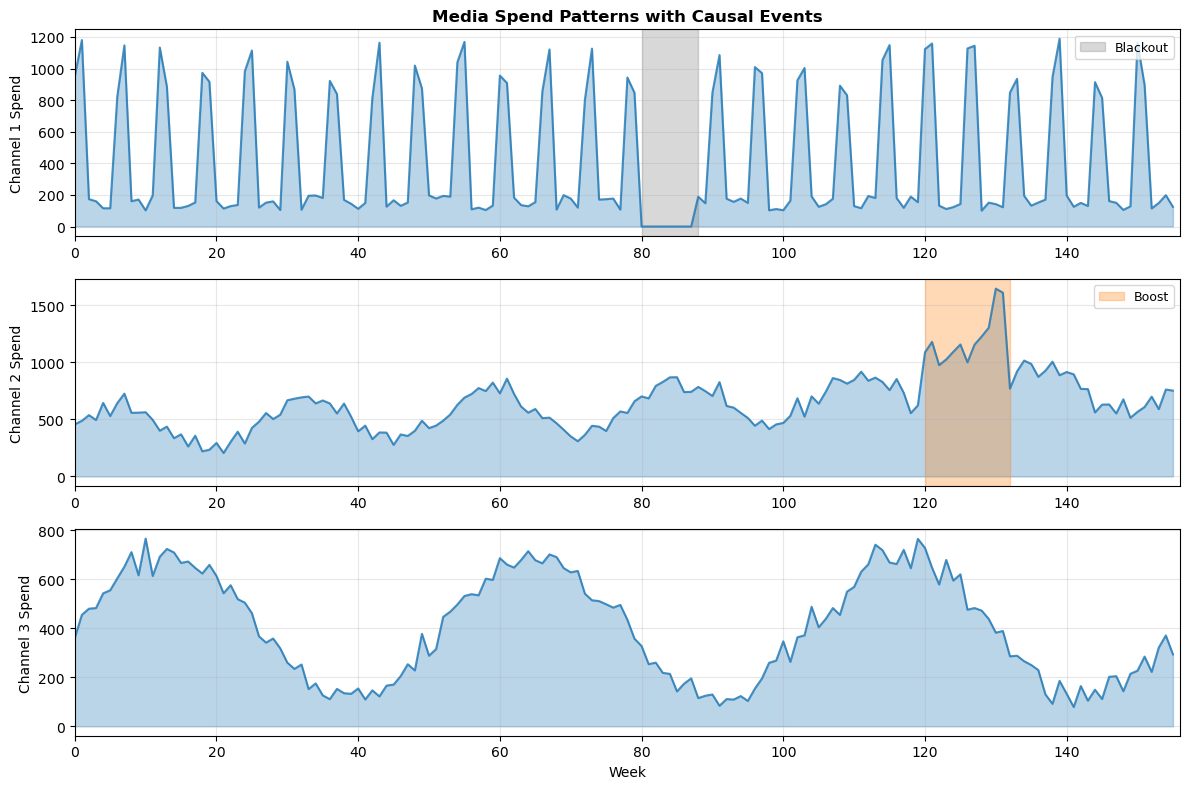

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
for i in range(3):
    ax = axes[i]
    channel_data = df[f'channel_{i+1}']
    ax.plot(df['week'], channel_data, color="tab:blue", linewidth=1.5, alpha=0.8)
    ax.fill_between(df['week'], channel_data, alpha=0.3, color="tab:blue")
    if i == 0:  
        blackout = true_params['causal_events']['channel_1_blackout']
        ax.axvspan(blackout['start_week'], 
                  blackout['start_week'] + blackout['duration'],
                  alpha=0.3, color="gray", label='Blackout')
    elif i == 1: 
        boost = true_params['causal_events']['channel_2_boost']
        ax.axvspan(boost['start_week'],
                  boost['start_week'] + boost['duration'],
                  alpha=0.3, color="tab:orange", label='Boost')
    ax.set_ylabel(f'Channel {i+1} Spend', fontsize=10)
    ax.set_xlim(0, 156)
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.set_title('Media Spend Patterns with Causal Events', fontsize=12, fontweight='bold')
    if ax.get_legend_handles_labels()[0]:
        ax.legend(loc='upper right', fontsize=9)
axes[-1].set_xlabel('Week', fontsize=10)
plt.tight_layout()
plt.show()

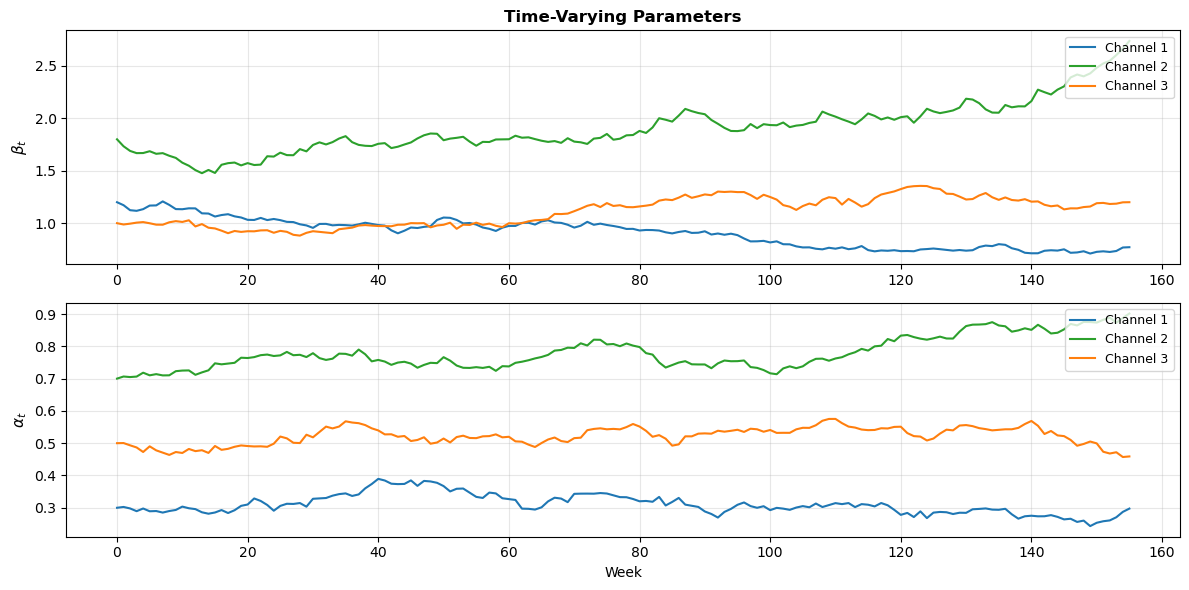

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
ax = axes[0]
colors = ["tab:blue", "tab:green", "tab:orange"]
for i in range(3):
    ax.plot(true_params['beta'][:, i],   
           label=f'Channel {i+1}', color=colors[i], linewidth=1.5)

ax.set_ylabel(r'$\beta_t$', fontsize=11)
ax.set_title('Time-Varying Parameters', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax = axes[1]
for i in range(3):
    ax.plot(true_params['alpha'][:, i], 
           label=f'Channel {i+1}', color=colors[i], linewidth=1.5)

ax.set_ylabel(r'$\alpha_t$', fontsize=11)
ax.set_xlabel('Week', fontsize=10)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

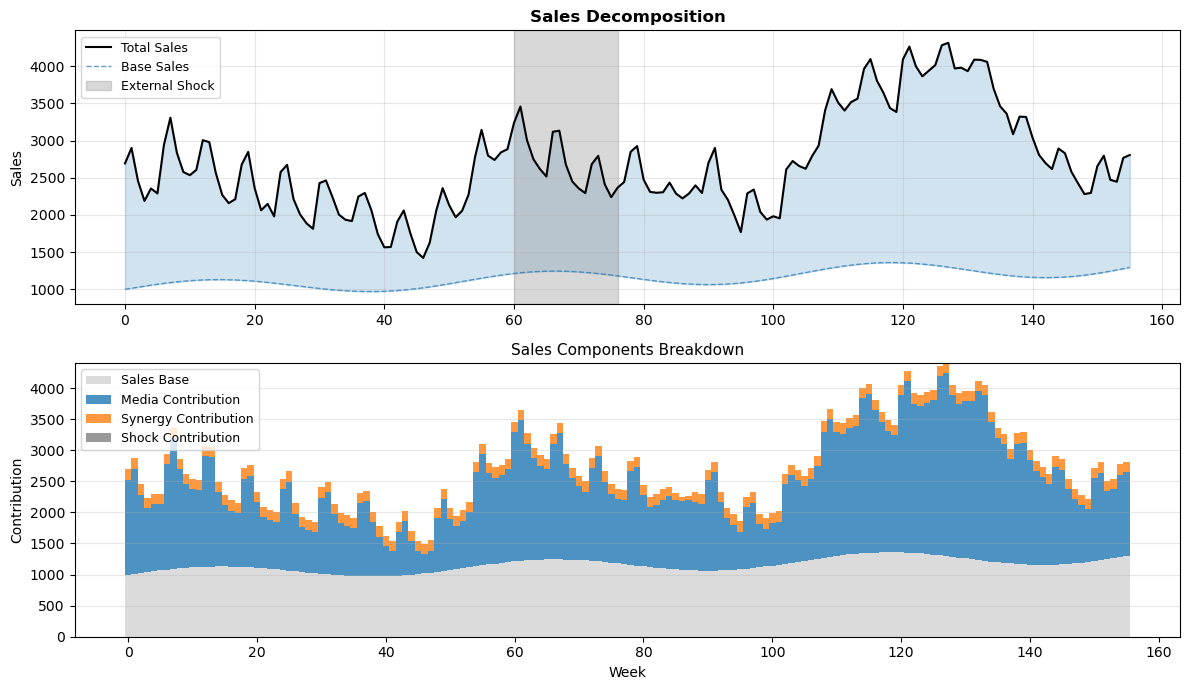

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
ax = axes[0]
ax.plot(df['week'], df['sales'], color="black", linewidth=1.5, label='Total Sales')
ax.plot(df['week'], df['sales_base'], color="tab:blue", linewidth=1, 
        linestyle='--', alpha=0.7, label='Base Sales')
ax.fill_between(df['week'], df['sales_base'], df['sales'], alpha=0.2, color="tab:blue")
shock = true_params['causal_events']['external_shock']
ax.axvspan(shock['start_week'], shock['start_week'] + shock['duration'],
          alpha=0.3, color="gray", label='External Shock')
ax.set_ylabel('Sales', fontsize=10)
ax.set_title('Sales Decomposition', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
ax = axes[1]
components = ['sales_base', 'media_contribution', 'synergy_contribution', 'shock_contribution']
colors = ["lightgray", "tab:blue", "tab:orange", "gray"]
bottom = np.zeros(len(df))
for comp, color in zip(components, colors):
    values = df[comp].values.copy()
    if comp == 'shock_contribution':
        values = np.maximum(values, 0)  
    ax.bar(df['week'], values, bottom=bottom, width=1, 
           label=comp.replace('_', ' ').title(), color=color, alpha=0.8)
    bottom += values
ax.set_xlabel('Week', fontsize=10)
ax.set_ylabel('Contribution', fontsize=10)
ax.set_title('Sales Components Breakdown', fontsize=11)
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [7]:
# Baseline Hierarchical Bayesian Model without Dynamic Parameters or Causal Priors
class hierarchical_B:
    def __init__(self):
        self.model = None
        self.idata = None
        self.fitted = False
        self.scaler_y = None
        self.scaler_X = None
        
    def h_modelcreate(
        self, 
        df: pd.DataFrame, 
        target_col: str = 'sales',
        channel_cols: Optional[list] = None,
        control_cols: Optional[list] = None,
        prior_use: bool = False,
        prior_info: Optional[Dict] = None
    ):
        if channel_cols is None:
            channel_cols = ['channel_1', 'channel_2', 'channel_3']
        n_channels = len(channel_cols)
        n_obs = len(df)
        y_raw = df[target_col].values
        X_media_raw = df[channel_cols].values
        self.scaler_y = StandardScaler()
        self.scaler_X = StandardScaler()
        y = self.scaler_y.fit_transform(y_raw.reshape(-1, 1)).flatten()
        X_media = self.scaler_X.fit_transform(X_media_raw)
        week = df['week'].values if 'week' in df.columns else np.arange(n_obs)
        seasonal_features = np.column_stack([
            np.sin(2 * np.pi * week / 52),
            np.cos(2 * np.pi * week / 52)
        ])
        # Build the PyMC model
        with pm.Model() as model:
            mu_alpha = pm.Beta('mu_alpha', alpha=2, beta=2) # Prior for adstock decay mean
            sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=0.2) # Prior for adstock decay std
            mu_lam = pm.HalfNormal('mu_lam', sigma=1.0) # Prior for saturation shape mean
            sigma_lam = pm.HalfNormal('sigma_lam', sigma=0.5) # Prior for saturation shape std
            mu_beta = pm.Normal('mu_beta', mu=0, sigma=0.5) # Prior for media effectiveness mean
            sigma_beta = pm.HalfNormal('sigma_beta', sigma=0.5) # Prior for media effectiveness std
            alpha = pm.Beta('alpha', alpha=2, beta=3, shape=n_channels) # Adstock decay per channel
            lam = pm.HalfNormal('lam', sigma=1.0, shape=n_channels) # Saturation shape per channel
            beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=n_channels) # Media effectiveness per channel
            # Apply causal calibration if specified
            if prior_use and prior_info:
                for i in range(n_channels):
                    channel_key = f'beta_{i+1}'
                    if channel_key in prior_info:
                        causal_info = prior_info[channel_key]
                        pm.Normal(f'causal_guidance_{i}', 
                                 mu=beta[i], 
                                 sigma=causal_info['std'] * 2,
                                 observed=causal_info['mean'])
                        print(f"Causal calibration information applied to beta[{i}]")
            intercept = pm.Normal('intercept', mu=0, sigma=0.5) # Baseline intercept
            gamma_seasonal = pm.Normal('gamma_seasonal', mu=0, sigma=0.2, shape=2) # Seasonality coefficients
            # Control variables if any
            if control_cols and len(control_cols) > 0: 
                X_control = df[control_cols].values
                gamma_control = pm.Normal('gamma_control', mu=0, sigma=0.3, shape=len(control_cols))
            else:
                X_control = None
            sigma = pm.HalfNormal('sigma', sigma=0.3) # Observation noise
            mu = intercept # Start with intercept
            # Media contribution with adstock and saturation
            for i in range(n_channels):
                x_raw = X_media[:, i]
                x_lagged = pt.concatenate([pt.zeros(1), x_raw[:-1]])
                x_adstock = x_raw + alpha[i] * x_lagged
                x_saturated = pt.tanh(lam[i] * x_adstock / (pt.max(x_adstock) + 1e-8))
                mu += beta[i] * x_saturated
            mu += pm.math.dot(seasonal_features, gamma_seasonal)
            # Control variables contribution
            if X_control is not None:
                mu += pm.math.dot(X_control, gamma_control)
            y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
            self.model = model
        return model
    # Fit the model using MCMC sampling
    def fit(
        self, 
        df: pd.DataFrame, 
        target_col: str = 'sales',
        channel_cols: Optional[list] = None,
        control_cols: Optional[list] = None,
        prior_use: bool = False,
        prior_info: Optional[Dict] = None,
        draws: int = 800,
        tune: int = 1000,
        chains: int = 2,
        target_accept: float = 0.95
    ):
        # Create the model
        self.h_modelcreate( 
            df, target_col, channel_cols, control_cols, 
            prior_use, prior_info
        )
        model_type = "Informative Priors" if prior_use else "Default Priors"
        print(f"Configuration: {chains} chains, {draws} draws, {tune} tune")
        
        with self.model:
            self.idata = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                target_accept=target_accept,
                max_treedepth=10,
                init='adapt_diag',
                random_seed=42,
                progressbar=False,
                return_inferencedata=True,
                cores=2
            )
        self.fitted = True
        return self
    # Diagnose model fit quality
    def diagnose(self):
        if not self.fitted:
            raise ValueError("Please fit the model first")
        divergences = self.idata.sample_stats.diverging.sum().values
        summary = az.summary(self.idata, var_names=['alpha', 'lam', 'beta'])
        # Key diagnostics
        max_rhat = summary['r_hat'].max()
        min_ess = summary['ess_bulk'].min()
        print(f"Number of Divergences: {divergences}")
        print(f"Max R-hat: {max_rhat:.4f}")
        print(f"Min ESS: {min_ess:.0f}")
        return {'divergences': int(divergences), 'max_rhat': float(max_rhat), 'min_ess': float(min_ess)}
    # Extract fitted parameters with uncertainty
    def get_parameters(self):
        if not self.fitted:
            raise ValueError("Please fit the model first")
        posterior = self.idata.posterior
        params = {}
        for param_name in ['alpha', 'lam', 'beta']:
            if param_name in posterior:
                params[param_name] = {
                    'mean': posterior[param_name].mean(dim=['chain', 'draw']).values,
                    'std': posterior[param_name].std(dim=['chain', 'draw']).values,
                    'q05': posterior[param_name].quantile(0.05, dim=['chain', 'draw']).values,
                    'q95': posterior[param_name].quantile(0.95, dim=['chain', 'draw']).values
                }
        return params

In [8]:
baseline_model = hierarchical_B()
baseline_model.fit(
    df=df,
    target_col='sales',
    channel_cols=['channel_1', 'channel_2', 'channel_3'],
    control_cols=['external_shock'],
    prior_use=False,
    draws=800,
    tune=800,
    chains=2,
    target_accept=0.9
)

Configuration: 2 chains, 800 draws, 800 tune


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_lam, sigma_lam, mu_beta, sigma_beta, alpha, lam, beta, intercept, gamma_seasonal, gamma_control, sigma]
Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [9]:
baseline_diagnostics = baseline_model.diagnose()

Number of Divergences: 0
Max R-hat: 1.0100
Min ESS: 565


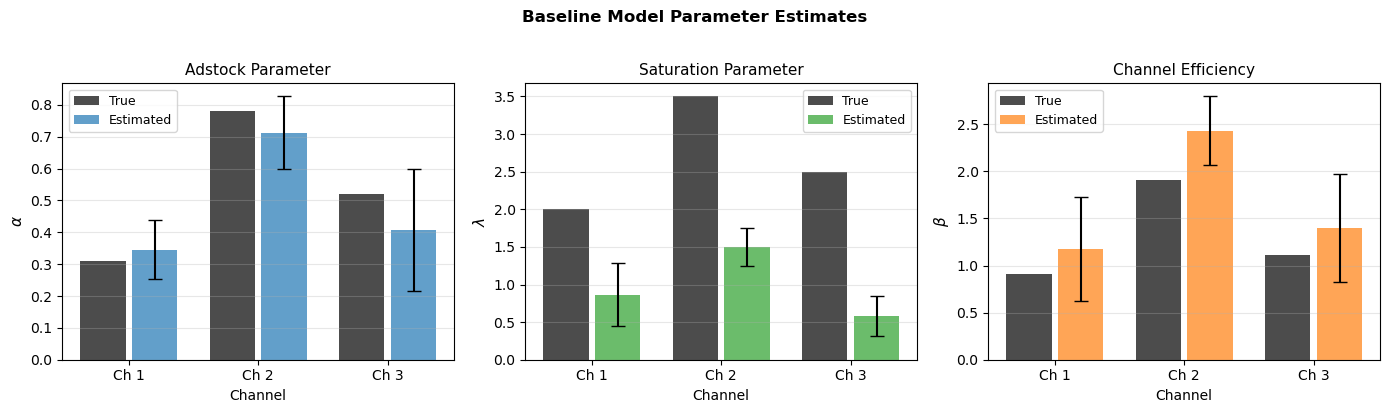

In [10]:
baseline_params = baseline_model.get_parameters()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
x_pos = np.arange(3)
# Plot alpha, lam, beta with true vs estimated
ax = axes[0]
means = baseline_params['alpha']['mean']
stds = baseline_params['alpha']['std']
true_vals = true_params['alpha'].mean(axis=0)   

ax.bar(x_pos - 0.2, true_vals, width=0.35, label='True',
       color="black", alpha=0.7)
ax.bar(x_pos + 0.2, means, width=0.35, yerr=stds,
       label='Estimated', color="tab:blue", alpha=0.7,
       capsize=5)
ax.set_ylabel(r'$\alpha$', fontsize=11)
ax.set_xlabel('Channel', fontsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(['Ch 1', 'Ch 2', 'Ch 3'])
ax.legend(fontsize=9)
ax.set_title('Adstock Parameter', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
# Plot lam
ax = axes[1]
means = baseline_params['lam']['mean']
stds = baseline_params['lam']['std']
true_vals = true_params['lam']   
ax.bar(x_pos - 0.2, true_vals, width=0.35, label='True',
       color="black", alpha=0.7)
ax.bar(x_pos + 0.2, means, width=0.35, yerr=stds,
       label='Estimated', color="tab:green", alpha=0.7,
       capsize=5)
ax.set_ylabel(r'$\lambda$', fontsize=11)
ax.set_xlabel('Channel', fontsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(['Ch 1', 'Ch 2', 'Ch 3'])
ax.legend(fontsize=9)
ax.set_title('Saturation Parameter', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
# Plot beta
ax = axes[2]
means = baseline_params['beta']['mean']
stds = baseline_params['beta']['std']
true_vals = true_params['beta'].mean(axis=0)   
ax.bar(x_pos - 0.2, true_vals, width=0.35, label='True',
       color="black", alpha=0.7)
ax.bar(x_pos + 0.2, means, width=0.35, yerr=stds,
       label='Estimated', color="tab:orange", alpha=0.7,
       capsize=5)
ax.set_ylabel(r'$\beta$', fontsize=11)
ax.set_xlabel('Channel', fontsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(['Ch 1', 'Ch 2', 'Ch 3'])
ax.legend(fontsize=9)
ax.set_title('Channel Efficiency', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Baseline Model Parameter Estimates', fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



In [11]:
# Causal Impact Analysis and Informative Priors Creation
class calibra_module:
    def __init__(self):
        self.causal_effects = {}
        self.prior_info = {}

    def causal_impact_analysis(
        self, 
        df: pd.DataFrame, 
        treatment_period: Tuple[int, int],
        treatment_var: str,
        outcome_var: str = 'sales'
    ) -> Dict:
        start_week, end_week = treatment_period
        
        # Prepare data
        df_analysis = df.copy()
        # Create treatment indicator variable
        df_analysis['treatment'] = 0
        df_analysis.loc[start_week:end_week-1, 'treatment'] = 1
        # Add time trend and seasonal variables
        df_analysis['time_trend'] = df_analysis['week']
        df_analysis['sin_seasonal'] = np.sin(2 * np.pi * df_analysis['week'] / 52)
        df_analysis['cos_seasonal'] = np.cos(2 * np.pi * df_analysis['week'] / 52)
        # Separate pre-period and treatment period data
        pre_period = df_analysis[df_analysis['treatment'] == 0].copy()
        treatment_period_data = df_analysis[df_analysis['treatment'] == 1].copy()
        # Ensure there is enough data
        if len(pre_period) == 0 or len(treatment_period_data) == 0:
            raise ValueError("Treatment or pre-treatment period data is empty")
        # Build list of control variables
        control_vars = []
        for col in df_analysis.columns: # Identify media channels as controls
            if col.startswith('channel_') and col != treatment_var:
                control_vars.append(col)
        control_vars.extend(['time_trend', 'sin_seasonal', 'cos_seasonal'])
        # External shock controls
        shock_controls = ['external_shock']
        for col in shock_controls:
            if col in df_analysis.columns:
                control_vars.append(col)
        available_controls = [col for col in control_vars if col in df_analysis.columns]
        
        print(f"Causal Impact Analysis: {treatment_var}")
        print(f"Treatment Period: Weeks {start_week}-{end_week-1}")
        print(f"Using Control Variables: {available_controls}")
        # Train counterfactual model using pre-period data
        X_pre = pre_period[available_controls].values
        y_pre = pre_period[outcome_var].values
        model = LinearRegression() # Simple linear regression for counterfactual
        model.fit(X_pre, y_pre)
        X_treatment = treatment_period_data[available_controls].values # Controls during treatment
        # Predict counterfactual sales during treatment period
        counterfactual = model.predict(X_treatment)
        actual = treatment_period_data[outcome_var].values # Actual sales during treatment
        # Calculate causal effect
        causal_effect = actual - counterfactual
        # Statistical inference
        effect_mean = np.mean(causal_effect)
        effect_std = np.std(causal_effect)
        n_obs = len(causal_effect)
        # t-test
        if n_obs > 1:
            t_stat, p_value = stats.ttest_1samp(causal_effect, 0)
        else:
            t_stat, p_value = 0, 1
        # ci
        if n_obs > 1:
            se = effect_std / np.sqrt(n_obs)
            ci_lower = effect_mean - 1.96 * se
            ci_upper = effect_mean + 1.96 * se
        else:
            ci_lower = ci_upper = effect_mean
            se = 0
        baseline_mean = np.mean(counterfactual)
        if baseline_mean != 0:
            relative_effect = effect_mean / baseline_mean
            relative_effect_pct = relative_effect * 100
        else:
            relative_effect = relative_effect_pct = 0
        cumulative_effect = np.sum(causal_effect)
        
        result = {
            'treatment_var': treatment_var,
            'treatment_period': treatment_period,
            'effect_mean': effect_mean,
            'effect_std': effect_std,
            'effect_se': se,
            'p_value': p_value,
            't_statistic': t_stat,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'relative_effect': relative_effect,
            'relative_effect_pct': relative_effect_pct,
            'cumulative_effect': cumulative_effect,
            'n_observations': n_obs,
            'baseline_mean': baseline_mean,
            'actual_mean': np.mean(actual),
            'model_r2': model.score(X_pre, y_pre)
        }
        self.causal_effects[treatment_var] = result
        
        print(f"Causal Effect: {effect_mean:.1f} ({relative_effect_pct:.1f}%)")
        print(f"95% CI: [{ci_lower:.1f}, {ci_upper:.1f}]") 
        print(f"p-value: {p_value:.4f}")
        print(f"Counterfactual Model R²: {result['model_r2']:.3f}")
        return result
    # Create informative priors based on causal effect results
    def create_informative_priors(self, causal_results: Dict, base_params: Dict) -> Dict:
        print("\nCreating Informative Priors...")
        print("-" * 30)
        prior_info = {}
        # Iterate over each treatment variable's causal result
        for treatment_var, result in causal_results.items():
            if 'channel_' in treatment_var:
                channel_id = treatment_var.split('_')[1]
                # Only create informative prior for statistically significant effects
                if result['p_value'] < 0.05:
                    # Convert causal effect into prior information for the beta parameter
                    relative_effect = abs(result['relative_effect'])
                    # Estimate a base beta value
                    if 'beta' in base_params:
                        base_beta_array = base_params['beta']
                        if isinstance(base_beta_array, np.ndarray):
                            if base_beta_array.ndim == 2:
                                # Time series, take average
                                base_beta = base_beta_array[:, int(channel_id) - 1].mean()
                            else:
                                base_beta = base_beta_array[int(channel_id) - 1]
                        else:
                            base_beta = 1.0
                    else:
                        base_beta = 1.0
                    effect_sign = 1 if result['effect_mean'] > 0 else -1 # Direction of effect
                    # Scale the adjustment factor to avoid extreme priors
                    adjustment_factor = 1 + effect_sign * min(relative_effect, 0.5) # Cap adjustment to 50%
                    informed_beta_mean = base_beta * adjustment_factor # Adjust base beta
                    # Set std based on confidence (lower p-value -> higher confidence -> lower std)
                    confidence_level = max(0.1, 1 - result['p_value'])
                    informed_beta_std = informed_beta_mean * (0.5 - 0.4 * confidence_level) #
                    # Ensure std is not too small
                    prior_info[f'beta_{channel_id}'] = {
                        'mean': informed_beta_mean,
                        'std': informed_beta_std,
                        'source_effect': result['effect_mean'],
                        'source_pvalue': result['p_value'],
                        'confidence': confidence_level
                    }
                    print(f"{treatment_var}: beta prior N({informed_beta_mean:.3f}, {informed_beta_std:.3f})")
                    print(f"Based on Causal Effect: {result['effect_mean']:.1f} (p={result['p_value']:.4f})")
                    
                else:
                    print(f"{treatment_var}: Causal effect not significant (p={result['p_value']:.4f}), skipping prior calibration")
        self.prior_info = prior_info
        return prior_info

In [12]:
causal_module = calibra_module() # Initialize module
causal_results = {}
blackout_event = true_params['causal_events']['channel_1_blackout'] # Channel 1 Blackout
# Perform causal impact analysis for Channel 1 Blackout
result_1 = causal_module.causal_impact_analysis(
    df=df,
    treatment_period=(blackout_event['start_week'], 
                     blackout_event['start_week'] + blackout_event['duration']),
    treatment_var='channel_1',
    outcome_var='sales'
)
causal_results['channel_1'] = result_1

Causal Impact Analysis: channel_1
Treatment Period: Weeks 80-87
Using Control Variables: ['channel_2', 'channel_3', 'channel_1_blackout', 'channel_2_boost', 'time_trend', 'sin_seasonal', 'cos_seasonal', 'external_shock']
Causal Effect: -433.2 (-15.7%)
95% CI: [-503.8, -362.7]
p-value: 0.0000
Counterfactual Model R²: 0.831


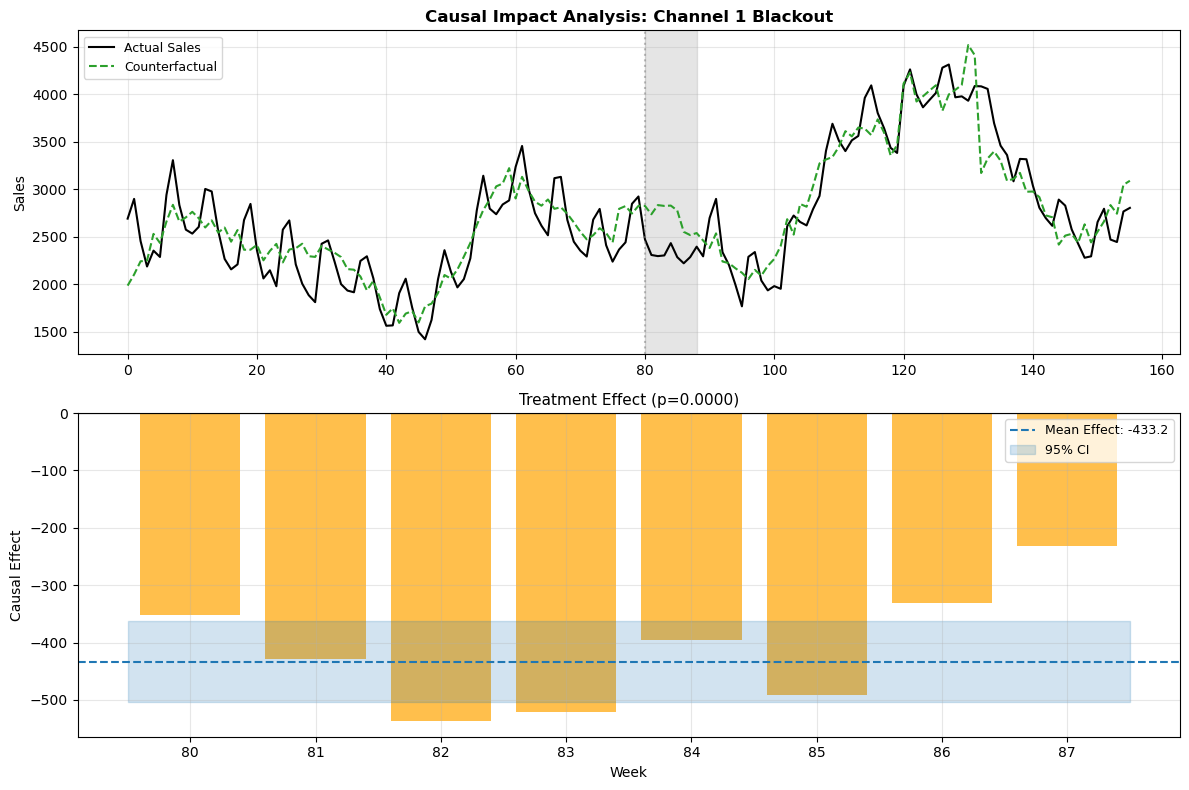

In [13]:
# Create informative priors based on causal results
start_week = blackout_event['start_week']
end_week = start_week + blackout_event['duration']
# Generate informative priors
df_vis = df.copy()
df_vis['treatment'] = 0
df_vis.loc[start_week:end_week-1, 'treatment'] = 1
df_vis['time_trend'] = df_vis['week']
df_vis['sin_seasonal'] = np.sin(2 * np.pi * df_vis['week'] / 52)
df_vis['cos_seasonal'] = np.cos(2 * np.pi * df_vis['week'] / 52)
# External shock controls
control_vars = ['channel_2', 'channel_3', 'time_trend', 'sin_seasonal', 'cos_seasonal', 'external_shock']
pre_period = df_vis[df_vis['treatment'] == 0]
X_pre = pre_period[control_vars].values
y_pre = pre_period['sales'].values
# Fit counterfactual model on pre-period
model = LinearRegression()
model.fit(X_pre, y_pre)
# Predict counterfactual for all periods
X_all = df_vis[control_vars].values
counterfactual_all = model.predict(X_all)
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
# Actual vs Counterfactual
ax = axes[0]
ax.plot(df_vis['week'], df_vis['sales'], color="black", 
        linewidth=1.5, label='Actual Sales')
ax.plot(df_vis['week'], counterfactual_all, color="tab:green", 
        linewidth=1.5, linestyle='--', label='Counterfactual')
ax.axvspan(start_week, end_week, alpha=0.2, color="gray")
ax.axvline(start_week, color="gray", linestyle=':', alpha=0.5)
ax.set_ylabel('Sales', fontsize=10)
ax.set_title('Causal Impact Analysis: Channel 1 Blackout', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
# Treatment Effect
ax = axes[1]
treatment_weeks = df_vis[df_vis['treatment'] == 1]['week'].values
actual_treatment = df_vis[df_vis['treatment'] == 1]['sales'].values
counterfactual_treatment = counterfactual_all[start_week:end_week]
causal_effect = actual_treatment - counterfactual_treatment
ax.bar(treatment_weeks, causal_effect, color="orange", alpha=0.7, width=0.8)
ax.axhline(0, color='black', linewidth=0.8)
ax.axhline(result_1['effect_mean'], color="tab:blue", 
          linestyle='--', label=f"Mean Effect: {result_1['effect_mean']:.1f}")
ax.fill_between([treatment_weeks[0]-0.5, treatment_weeks[-1]+0.5], 
                result_1['ci_lower'], result_1['ci_upper'], 
                alpha=0.2, color="tab:blue", label='95% CI')
ax.set_xlabel('Week', fontsize=10)
ax.set_ylabel('Causal Effect', fontsize=10)
ax.set_title(f'Treatment Effect (p={result_1["p_value"]:.4f})', fontsize=11)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [14]:
boost_event = true_params['causal_events']['channel_2_boost']
result_2 = causal_module.causal_impact_analysis(
    df=df,
    treatment_period=(boost_event['start_week'],
                     boost_event['start_week'] + boost_event['duration']),
    treatment_var='channel_2',
    outcome_var='sales'
)
causal_results['channel_2'] = result_2

Causal Impact Analysis: channel_2
Treatment Period: Weeks 120-131
Using Control Variables: ['channel_1', 'channel_3', 'channel_1_blackout', 'channel_2_boost', 'time_trend', 'sin_seasonal', 'cos_seasonal', 'external_shock']
Causal Effect: 517.1 (14.6%)
95% CI: [362.6, 671.5]
p-value: 0.0001
Counterfactual Model R²: 0.743


In [15]:
prior_info = causal_module.create_informative_priors(causal_results, true_params)


Creating Informative Priors...
------------------------------
channel_1: beta prior N(0.767, 0.077)
Based on Causal Effect: -433.2 (p=0.0000)
channel_2: beta prior N(2.182, 0.218)
Based on Causal Effect: 517.1 (p=0.0001)


In [16]:
calibrated_model = hierarchical_B()
calibrated_model.fit(
    df=df,
    target_col='sales',
    channel_cols=['channel_1', 'channel_2', 'channel_3'],
    control_cols=['external_shock'],
    prior_use=True,
    prior_info=prior_info,
    draws=800,
    tune=800,
    chains=2,
    target_accept=0.9
)

Causal calibration information applied to beta[0]
Causal calibration information applied to beta[1]
Configuration: 2 chains, 800 draws, 800 tune


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_lam, sigma_lam, mu_beta, sigma_beta, alpha, lam, beta, intercept, gamma_seasonal, gamma_control, sigma]
Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [17]:
class modelcompare:
    def __init__(self):
        self.results = {}

    def compare_parameter_recovery(
        self, 
        baseline_model: hierarchical_B,
        calibrated_model: hierarchical_B, 
        true_params: Dict
    ) -> Dict:
        """
        Compare parameter recovery accuracy between two models.

        Parameters
        ----------
        baseline_model : hierarchical_B
            Baseline model (without causal calibration)
        calibrated_model : hierarchical_B  
            Calibrated model (with causal priors)
        true_params : Dict
            Ground-truth parameter values from the simulator

        Returns
        -------
        Dict
            A dictionary containing recovery errors, improvements, and summary statistics.
        """

        print("\nParameter Recovery Accuracy Comparison")

        # Retrieve estimated parameters
        baseline_params = baseline_model.get_parameters()
        calibrated_params = calibrated_model.get_parameters()
        comparison_results = {
            'baseline_errors': {},
            'calibrated_errors': {},
            'improvements': {},
            'r2_scores': {},
            'rmse': {},
            'summary': {}
        }

        print("Parameter   |  Baseline Error%  |  Calibrated Error%  |  Improvement%")
        all_baseline_errors = []
        all_calibrated_errors = []

        # Loop through key parameter groups
        for param_name in ['alpha', 'lam', 'beta']:
            if param_name in true_params and param_name in baseline_params:
                true_vals = true_params[param_name]
                if isinstance(true_vals, np.ndarray) and true_vals.ndim == 2:
                    true_vals = true_vals.mean(axis=0)
                elif not isinstance(true_vals, np.ndarray):
                    true_vals = np.array([true_vals])
                # Compute percentage errors (MAPE)
                baseline_means = baseline_params[param_name]['mean']
                calibrated_means = calibrated_params[param_name]['mean']
                baseline_errors = np.abs(baseline_means - true_vals) / np.abs(true_vals) * 100
                calibrated_errors = np.abs(calibrated_means - true_vals) / np.abs(true_vals) * 100
                # Compute RMSE
                rmse_baseline = np.sqrt(mean_squared_error(true_vals, baseline_means))
                rmse_calibrated = np.sqrt(mean_squared_error(true_vals, calibrated_means))
                # Compute R²
                r2_baseline = r2_score(true_vals, baseline_means)
                r2_calibrated = r2_score(true_vals, calibrated_means)
                comparison_results['baseline_errors'][param_name] = baseline_errors
                comparison_results['calibrated_errors'][param_name] = calibrated_errors
                comparison_results['improvements'][param_name] = baseline_errors - calibrated_errors
                comparison_results['rmse'][param_name] = {
                    'baseline': rmse_baseline,
                    'calibrated': rmse_calibrated
                }
                comparison_results['r2_scores'][param_name] = {
                    'baseline': r2_baseline,
                    'calibrated': r2_calibrated
                }
                # Collect for overall stats
                all_baseline_errors.extend(baseline_errors)
                all_calibrated_errors.extend(calibrated_errors)
                # Print detailed comparison
                for i, (true_val, base_err, calib_err, improve) in enumerate(
                    zip(true_vals, baseline_errors, calibrated_errors, baseline_errors - calibrated_errors)
                ):
                    print(f"{param_name}[{i}]     |    {base_err:8.1f}%     |    {calib_err:8.1f}%     |    {improve:+6.1f}%")
                print(f"    RMSE ({param_name}): baseline={rmse_baseline:.3f}, calibrated={rmse_calibrated:.3f}")
                print(f"    R² ({param_name}): baseline={r2_baseline:.3f}, calibrated={r2_calibrated:.3f}\n")

        # Compute overall averages
        mean_baseline_error = np.mean(all_baseline_errors)
        mean_calibrated_error = np.mean(all_calibrated_errors)
        mean_improvement = mean_baseline_error - mean_calibrated_error
        improvement_percentage = (mean_improvement / mean_baseline_error) * 100 if mean_baseline_error > 0 else 0

        comparison_results['summary'] = {
            'baseline_mean_error': mean_baseline_error,
            'calibrated_mean_error': mean_calibrated_error, 
            'mean_improvement': mean_improvement,
            'improvement_percentage': improvement_percentage,
            'better_params': sum(1 for base, calib in zip(all_baseline_errors, all_calibrated_errors) if calib < base),
            'total_params': len(all_baseline_errors)
        }

        print(f"Overall     |    {mean_baseline_error:8.1f}%     |    {mean_calibrated_error:8.1f}%     |    {mean_improvement:+6.1f}%")
        print(f"\nImprovement Summary:")
        print(f"  Mean Error Reduction: {mean_improvement:.1f} percentage points ({improvement_percentage:+.1f}%)")
        print(f"  Improved Parameters: {comparison_results['summary']['better_params']}/{comparison_results['summary']['total_params']}")

        # Interpret performance gain
        if improvement_percentage > 15:
            print("\nCausal calibration significantly improved parameter recovery accuracy!")
        elif improvement_percentage > 5:
            print("\nCausal calibration effectively improved parameter recovery accuracy.")
        elif improvement_percentage > 0:
            print("\nCausal calibration slightly improved parameter recovery accuracy.")
        else:
            print("\nCausal calibration did not improve parameter recovery accuracy.")

        self.results = comparison_results
        return comparison_results

    def generate_comparison_report(self) -> str:
        if not self.results:
            return "Comparison analysis has not been executed."

        summary = self.results['summary']

        report = f"""
Hierarchical Bayesian MMM – Causal Calibration Evaluation

Model Comparison Results:
- Baseline (uncalibrated) mean parameter error: {summary['baseline_mean_error']:.1f}%
- Calibrated (with causal priors) mean parameter error: {summary['calibrated_mean_error']:.1f}%
- Mean improvement: {summary['mean_improvement']:.1f} percentage points
- Relative improvement: {summary['improvement_percentage']:+.1f}%
- Improved parameters: {summary['better_params']}/{summary['total_params']} ({summary['better_params']/summary['total_params']*100:.1f}%)

Parameter-wise Improvements:
"""
        for param_name, improvements in self.results['improvements'].items():
            mean_improvement = np.mean(improvements)
            r2_base = self.results['r2_scores'][param_name]['baseline']
            r2_calib = self.results['r2_scores'][param_name]['calibrated']
            rmse_base = self.results['rmse'][param_name]['baseline']
            rmse_calib = self.results['rmse'][param_name]['calibrated']
            report += (
                f"• {param_name}: Avg improvement {mean_improvement:+.1f} pp | "
                f"RMSE: {rmse_base:.3f}→{rmse_calib:.3f} | "
                f"R²: {r2_base:.3f}→{r2_calib:.3f}\n"
            )

        return report


In [18]:
from sklearn.metrics import r2_score

validator = modelcompare()
comparison_results = validator.compare_parameter_recovery(
    baseline_model=baseline_model,
    calibrated_model=calibrated_model,
    true_params=true_params
)


Parameter Recovery Accuracy Comparison
Parameter   |  Baseline Error%  |  Calibrated Error%  |  Improvement%
alpha[0]     |        11.2%     |        11.1%     |      +0.1%
alpha[1]     |         8.6%     |         8.7%     |      -0.2%
alpha[2]     |        21.9%     |        22.1%     |      -0.2%
    RMSE (alpha): baseline=0.079, calibrated=0.080
    R² (alpha): baseline=0.831, calibrated=0.827

lam[0]     |        56.9%     |        43.4%     |     +13.6%
lam[1]     |        57.2%     |        55.5%     |      +1.7%
lam[2]     |        76.6%     |        75.3%     |      +1.3%
    RMSE (lam): baseline=1.730, calibrated=1.641
    R² (lam): baseline=-6.695, calibrated=-5.925

beta[0]     |        28.8%     |        13.5%     |     +15.2%
beta[1]     |        27.7%     |        22.3%     |      +5.4%
beta[2]     |        26.2%     |        20.5%     |      +5.6%
    RMSE (beta): baseline=0.379, calibrated=0.287
    R² (beta): baseline=0.220, calibrated=0.552

Overall     |        35.

In [19]:
report = validator.generate_comparison_report()
print(report)


Hierarchical Bayesian MMM – Causal Calibration Evaluation

Model Comparison Results:
- Baseline (uncalibrated) mean parameter error: 35.0%
- Calibrated (with causal priors) mean parameter error: 30.3%
- Mean improvement: 4.7 percentage points
- Relative improvement: +13.5%
- Improved parameters: 7/9 (77.8%)

Parameter-wise Improvements:
• alpha: Avg improvement -0.1 pp | RMSE: 0.079→0.080 | R²: 0.831→0.827
• lam: Avg improvement +5.5 pp | RMSE: 1.730→1.641 | R²: -6.695→-5.925
• beta: Avg improvement +8.8 pp | RMSE: 0.379→0.287 | R²: 0.220→0.552



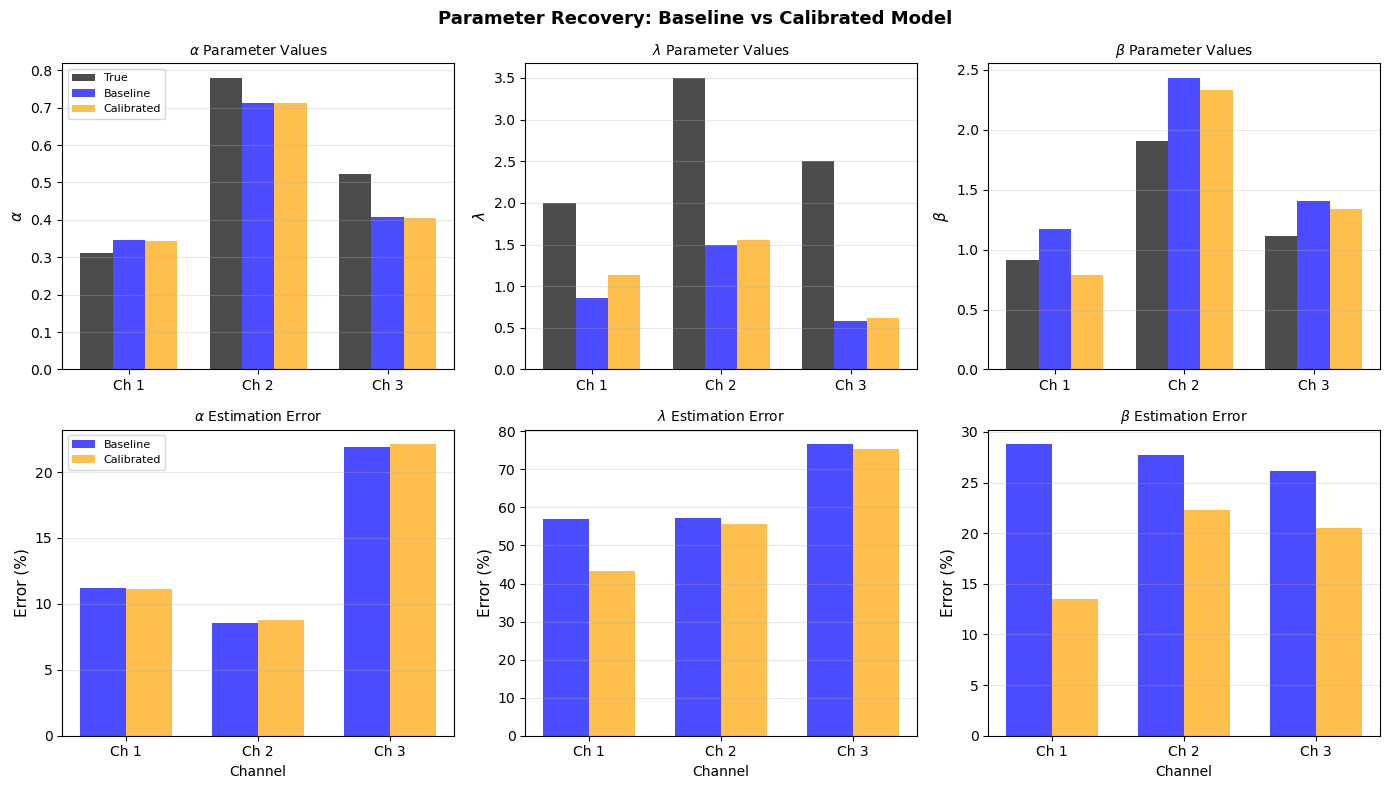

In [20]:
# Visualization of Parameter Recovery Comparison
calibrated_params = calibrated_model.get_parameters()
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
param_names = ['alpha', 'lam', 'beta']
param_labels = [r'$\alpha$', r'$\lambda$', r'$\beta$']
# Plot parameter values and errors
for row in range(2):
    for col, (param_name, param_label) in enumerate(zip(param_names, param_labels)):
        ax = axes[row, col]
        true_vals = true_params[param_name]
        if isinstance(true_vals, np.ndarray) and true_vals.ndim == 2:
            true_vals = true_vals.mean(axis=0)
        if row == 0: 
            x_pos = np.arange(3)
            baseline_means = baseline_params[param_name]['mean']
            calibrated_means = calibrated_params[param_name]['mean']
            width = 0.25
            ax.bar(x_pos - width, true_vals, width, label='True', 
                  color='black', alpha=0.7)
            ax.bar(x_pos, baseline_means, width, label='Baseline', 
                  color='blue', alpha=0.7)
            ax.bar(x_pos + width, calibrated_means, width, label='Calibrated', 
                  color='orange', alpha=0.7)
            ax.set_ylabel(param_label, fontsize=11)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(['Ch 1', 'Ch 2', 'Ch 3'])
            if col == 0:
                ax.legend(fontsize=8, loc='upper left')
            ax.set_title(f'{param_label} Parameter Values', fontsize=10)
        else:
            baseline_errors = comparison_results['baseline_errors'][param_name]
            calibrated_errors = comparison_results['calibrated_errors'][param_name]
            x_pos = np.arange(3)
            width = 0.35
            ax.bar(x_pos - width/2, baseline_errors, width, label='Baseline', 
                  color='blue', alpha=0.7)
            ax.bar(x_pos + width/2, calibrated_errors, width, label='Calibrated', 
                  color='orange', alpha=0.7)
            ax.set_ylabel('Error (%)', fontsize=11)
            ax.set_xlabel('Channel', fontsize=10)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(['Ch 1', 'Ch 2', 'Ch 3'])
            if col == 0:
                ax.legend(fontsize=8)
            ax.set_title(f'{param_label} Estimation Error', fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Parameter Recovery: Baseline vs Calibrated Model', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
class dynamic_b:
    def __init__(self):
        self.model = None
        self.idata = None
        self.fitted = False
        self.scaler_y = None
        self.scaler_X = None
        self.dynamic_channels = None
    # Build the dynamic hierarchical Bayesian MMM
    def dynamicmodel(
        self,
        df: pd.DataFrame,
        target_col: str = 'sales',
        channel_cols: Optional[list] = None,
        control_cols: Optional[list] = None,
        dynamic_channels: Optional[list] = None,
        prior_use: bool = False,
        prior_info: Optional[Dict] = None
    ):
        if channel_cols is None:
            channel_cols = ['channel_1', 'channel_2', 'channel_3']
        if dynamic_channels is None:
            # Default: select 1–2 key channels (e.g., Channel 2’s beta)
            dynamic_channels = [1]
        n_channels = len(channel_cols)
        n_obs = len(df)
        y_raw = df[target_col].values
        X_media_raw = df[channel_cols].values
        self.scaler_y = StandardScaler()
        self.scaler_X = StandardScaler()
        y = self.scaler_y.fit_transform(y_raw.reshape(-1, 1)).flatten()
        X_media = self.scaler_X.fit_transform(X_media_raw)
        # Seasonal features
        week = df['week'].values if 'week' in df.columns else np.arange(n_obs)
        seasonal_features = np.column_stack([
            np.sin(2 * np.pi * week / 52),
            np.cos(2 * np.pi * week / 52)
        ])
        print(f"Building dynamic model: dynamic channels = {[channel_cols[i] for i in dynamic_channels]}")
        with pm.Model() as model:
            # Hierarchical hyperparameters (same as static model)
            mu_alpha = pm.Beta('mu_alpha', alpha=2, beta=2)
            sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=0.2)
            mu_lam = pm.HalfNormal('mu_lam', sigma=1.0)
            sigma_lam = pm.HalfNormal('sigma_lam', sigma=0.5)
            mu_beta = pm.Normal('mu_beta', mu=0, sigma=0.5)
            sigma_beta = pm.HalfNormal('sigma_beta', sigma=0.5)
            # Channel-level parameters
            alpha = pm.Beta('alpha', alpha=2, beta=3, shape=n_channels)
            lam = pm.HalfNormal('lam', sigma=1.0, shape=n_channels)
            # Dynamic Beta parameters (Gaussian Random Walk)
            beta_list = []
            for i in range(n_channels):
                if i in dynamic_channels:
                    print(f"  Channel {i+1}: Gaussian Random Walk β_t = β_(t-1) + ε_t")
                    sigma_walk = pm.HalfNormal(f'sigma_walk_{i}', sigma=0.03)
                    # Initial value β_0
                    if prior_use and prior_info and f'beta_{i+1}' in prior_info:
                        causal_info = prior_info[f'beta_{i+1}']
                        beta_init = pm.Normal(
                            f'beta_{i}_init',
                            mu=causal_info['mean'],
                            sigma=causal_info['std']
                        )
                        print(f"    Using causal calibration prior: N({causal_info['mean']:.3f}, {causal_info['std']:.3f})")
                    else:
                        beta_init = pm.Normal(f'beta_{i}_init', mu=mu_beta, sigma=sigma_beta)
                    # Gaussian Random Walk
                    inno = pm.Normal(
                        f'beta_{i}_inno',
                        mu=0,
                        sigma=sigma_walk,
                        shape=n_obs - 1
                    )
                    beta_traj = [beta_init]
                    cumsum = beta_init
                    for t in range(n_obs - 1):
                        cumsum = cumsum + inno[t]
                        beta_traj.append(cumsum)
                    beta_t = pt.stack(beta_traj)
                    beta_list.append(beta_t)
                else:
                    print(f"  Channel {i+1}: Static parameter")
                    if prior_use and prior_info and f'beta_{i+1}' in prior_info:
                        causal_info = prior_info[f'beta_{i+1}']
                        beta_static = pm.Normal(
                            f'beta_{i}_static',
                            mu=causal_info['mean'],
                            sigma=causal_info['std']
                        )
                        pm.Normal(
                            f'causal_guidance_{i}',
                            mu=beta_static,
                            sigma=causal_info['std'] * 2,
                            observed=causal_info['mean']
                        )
                    else:
                        beta_static = pm.Normal(f'beta_{i}_static', mu=mu_beta, sigma=sigma_beta)
                    beta_t = pt.ones(n_obs) * beta_static
                    beta_list.append(beta_t)
            beta_all = pt.stack(beta_list, axis=1)
            # Other parameters
            intercept = pm.Normal('intercept', mu=0, sigma=0.5)
            gamma_seasonal = pm.Normal('gamma_seasonal', mu=0, sigma=0.2, shape=2)
            if control_cols and len(control_cols) > 0:
                X_control = df[control_cols].values
                gamma_control = pm.Normal('gamma_control', mu=0, sigma=0.3, shape=len(control_cols))
            else:
                X_control = None
            sigma = pm.HalfNormal('sigma', sigma=0.3)
            # MMM transformation using time-varying betas
            mu = intercept * pt.ones(n_obs)
            for i in range(n_channels):
                x_raw = X_media[:, i]
                x_lagged = pt.concatenate([pt.zeros(1), x_raw[:-1]])
                x_adstock = x_raw + alpha[i] * x_lagged
                x_saturated = pt.tanh(lam[i] * x_adstock / (pt.max(x_adstock) + 1e-8))
                mu += beta_all[:, i] * x_saturated
            mu += pm.math.dot(seasonal_features, gamma_seasonal)
            if X_control is not None:
                mu += pm.math.dot(X_control, gamma_control)
            y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
            self.model = model
            self.dynamic_channels = dynamic_channels
        return model
    # Fit the model using MCMC
    def fit(
        self,
        df: pd.DataFrame,
        target_col: str = 'sales',
        channel_cols: Optional[list] = None,
        control_cols: Optional[list] = None,
        dynamic_channels: Optional[list] = None,
        prior_use: bool = False,
        prior_info: Optional[Dict] = None,
        draws: int = 1000,
        tune: int = 1000,
        chains: int = 2,
        target_accept: float = 0.95
    ):
        self.dynamicmodel(df, target_col, channel_cols, control_cols, dynamic_channels, prior_use, prior_info)
        model_type = "Dynamic + Causal Calibration" if prior_use else "Dynamic"
        print(f"\nFitting {model_type} Hierarchical Bayesian MMM...")
        print(f"Configuration: {chains} chains, {draws} draws, {tune} tuning steps")
        start_time = time.time()
        with self.model:
            self.idata = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                target_accept=target_accept,
                max_treedepth=12,
                init='jitter+adapt_diag',
                random_seed=42,
                progressbar=False,
                return_inferencedata=True,
                cores=2,
                compute_convergence_checks=False,
                keep_warning_stat=False
            )
        self.fitted = True
        return self

    def predict(self, df: pd.DataFrame, channel_cols: Optional[list] = None) -> np.ndarray:
        # Generate posterior predictive mean estimates
        if channel_cols is None:
            channel_cols = ['channel_1', 'channel_2', 'channel_3']
        posterior = self.idata.posterior
        X_media = self.scaler_X.transform(df[channel_cols].values)
        n_obs = len(df)
        predictions = []

        for chain in range(posterior.dims['chain']):
            for draw in range(min(posterior.dims['draw'], 100)):
                pred = np.zeros(n_obs)
                pred += posterior['intercept'].isel(chain=chain, draw=draw).values
                for i in range(len(channel_cols)):
                    alpha_i = posterior['alpha'].isel(chain=chain, draw=draw, alpha_dim_0=i).values
                    lam_i = posterior['lam'].isel(chain=chain, draw=draw, lam_dim_0=i).values
                    if i in self.dynamic_channels:
                        beta_init = posterior[f'beta_{i}_init'].isel(chain=chain, draw=draw).values
                        inno = posterior[f'beta_{i}_inno'].isel(chain=chain, draw=draw).values
                        beta_traj = np.zeros(n_obs)
                        beta_traj[0] = beta_init
                        for t in range(1, min(n_obs, len(inno) + 1)):
                            beta_traj[t] = beta_traj[t - 1] + inno[t - 1]
                        if n_obs > len(inno) + 1:
                            beta_traj[len(inno) + 1:] = beta_traj[len(inno)]
                        beta_i = beta_traj
                    else:
                        beta_i = np.ones(n_obs) * posterior[f'beta_{i}_static'].isel(chain=chain, draw=draw).values
                    x_raw = X_media[:, i]
                    x_adstock = np.zeros(n_obs)
                    x_adstock[0] = x_raw[0]
                    for t in range(1, n_obs):
                        x_adstock[t] = x_raw[t] + alpha_i * x_adstock[t - 1]
                    x_saturated = np.tanh(lam_i * x_adstock / (np.max(x_adstock) + 1e-8))
                    pred += beta_i * x_saturated
                week = df['week'].values if 'week' in df.columns else np.arange(n_obs)
                seasonal_features = np.column_stack([
                    np.sin(2 * np.pi * week / 52),
                    np.cos(2 * np.pi * week / 52)
                ])
                gamma = posterior['gamma_seasonal'].isel(chain=chain, draw=draw).values
                pred += seasonal_features @ gamma
                predictions.append(pred)
        predictions = np.array(predictions)
        predictions_original = self.scaler_y.inverse_transform(predictions.T).T
        return predictions_original.mean(axis=0)

    def diagnose(self):
        print("\nDynamic Hierarchical Bayesian MMM Diagnostics")
        divergences = self.idata.sample_stats.diverging.sum().values
        summary = az.summary(self.idata, var_names=['alpha', 'lam', 'sigma'])
        max_rhat = summary['r_hat'].max()
        min_ess = summary['ess_bulk'].min()
        print(f"Divergences: {divergences}")
        print(f"Max R-hat: {max_rhat:.4f}")
        print(f"Min ESS: {min_ess:.0f}")
        for i in self.dynamic_channels:
            if f'sigma_walk_{i}' in self.idata.posterior:
                walk_sigma = self.idata.posterior[f'sigma_walk_{i}'].mean().values
                print(f"Channel {i+1} random walk σ: {walk_sigma:.4f}")
        return {'divergences': int(divergences), 'max_rhat': float(max_rhat), 'min_ess': float(min_ess)}

    def get_parameters(self):
        posterior = self.idata.posterior
        params = {}
        for param_name in ['alpha', 'lam']:
            if param_name in posterior:
                params[param_name] = {
                    'mean': posterior[param_name].mean(dim=['chain', 'draw']).values,
                    'std': posterior[param_name].std(dim=['chain', 'draw']).values,
                    'q05': posterior[param_name].quantile(0.05, dim=['chain', 'draw']).values,
                    'q95': posterior[param_name].quantile(0.95, dim=['chain', 'draw']).values
                }
        n_channels = 3
        beta_means = np.zeros(n_channels)
        beta_stds = np.zeros(n_channels)
        for i in range(n_channels):
            if i in self.dynamic_channels:
                beta_init = posterior[f'beta_{i}_init'].mean().values
                inno = posterior[f'beta_{i}_inno'].mean(dim=['chain', 'draw']).values
                trajectory = [beta_init]
                cumsum = beta_init
                for innov in inno:
                    cumsum += innov
                    trajectory.append(cumsum)
                beta_means[i] = np.mean(trajectory)
                beta_stds[i] = np.std(trajectory)
            else:
                beta_means[i] = posterior[f'beta_{i}_static'].mean().values
                beta_stds[i] = posterior[f'beta_{i}_static'].std().values
        params['beta'] = {
            'mean': beta_means,
            'std': beta_stds,
            'q05': beta_means - 1.96 * beta_stds,
            'q95': beta_means + 1.96 * beta_stds
        }
        return params

    def dynamic_para(self):
        # Visualize dynamic beta trajectories for channels with time-varying parameters
        posterior = self.idata.posterior
        fig, axes = plt.subplots(len(self.dynamic_channels), 1, figsize=(12, 4 * len(self.dynamic_channels)))
        if len(self.dynamic_channels) == 1:
            axes = [axes]
        for idx, i in enumerate(self.dynamic_channels):
            beta_init = posterior[f'beta_{i}_init'].values.flatten()
            inno = posterior[f'beta_{i}_inno'].values
            n_samples = len(beta_init)
            n_time = inno.shape[-1] + 1
            trajs = np.zeros((n_samples, n_time))
            for s in range(n_samples):
                trajs[s, 0] = beta_init[s]
                cumsum = beta_init[s]
                for t in range(n_time - 1):
                    cumsum += inno.reshape(n_samples, -1)[s, t]
                    trajs[s, t + 1] = cumsum
            mean_traj = trajs.mean(axis=0) #
            q05_traj = np.quantile(trajs, 0.05, axis=0)
            q95_traj = np.quantile(trajs, 0.95, axis=0)
            time_points = np.arange(n_time)
            axes[idx].plot(time_points, mean_traj, 'b-', label='Posterior Mean', linewidth=2)
            axes[idx].fill_between(time_points, q05_traj, q95_traj, alpha=0.3, label='90% Credible Interval')
            axes[idx].set_xlabel('Time (weeks)')
            axes[idx].set_ylabel(f'Beta_{i+1}(t)')
            axes[idx].set_title(f'Gaussian Random Walk Trajectory for Channel {i+1} Beta')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        return fig


In [22]:
# Dynamic Model Validation Class
class dynamic_valid:
    def __init__(self):
        self.results = {}
        self.cv_details = []
    # Summarize cross-validation results
    def cross_valid(
        self,
        df: pd.DataFrame,
        true_params: Dict,
        n_splits: int = 3,
        test_size: int = 26,
        channel_cols: Optional[list] = None,
        control_cols: Optional[list] = None
    ) -> Dict:
        if channel_cols is None:
            channel_cols = ['channel_1', 'channel_2', 'channel_3']
        print("Time-Series Cross-Validation: Dynamic vs Static Models")
        results = {
            'static': {'mape': [], 'rmse': []},
            'dynamic': {'mape': [], 'rmse': []}
        }
        n_obs = len(df)
        # Ensure enough data for splits
        for split in range(n_splits):
            test_end = n_obs - split * test_size
            test_start = test_end - test_size
            if test_start < 52:  # Ensure at least one year of training data
                continue
            # Split data
            train_df = df.iloc[:test_start].copy()
            test_df = df.iloc[test_start:test_end].copy()
            print(f"\nSplit {split + 1}/{n_splits}:")
            print(f"  Training Set: Weeks 0–{test_start - 1} (n={test_start})")
            print(f"  Test Set: Weeks {test_start}–{test_end - 1} (n={test_size})")
            # Fit static model
            static_model = hierarchical_B()
            static_model.fit(
                train_df, 'sales', channel_cols, control_cols,
                draws=800, tune=1000, chains=2
            )
            # Fit dynamic model
            dynamic_model = dynamic_b()
            dynamic_model.fit(
                train_df, 'sales', channel_cols, control_cols,
                dynamic_channels=[1],  # Channel 2 as dynamic
                draws=1000, tune=1000, chains=2
            )
            # Prediction and evaluation
            y_true = test_df['sales'].values
            y_pred_static = self.s_pred(static_model, test_df, channel_cols)
            y_pred_dynamic = dynamic_model.predict(test_df, channel_cols)
            # Compute errors
            mape_static = mean_absolute_percentage_error(y_true, y_pred_static) * 100
            rmse_static = np.sqrt(mean_squared_error(y_true, y_pred_static))
            mape_dynamic = mean_absolute_percentage_error(y_true, y_pred_dynamic) * 100
            rmse_dynamic = np.sqrt(mean_squared_error(y_true, y_pred_dynamic))
            results['static']['mape'].append(mape_static)
            results['static']['rmse'].append(rmse_static)
            results['dynamic']['mape'].append(mape_dynamic)
            results['dynamic']['rmse'].append(rmse_dynamic)
            print(f"  Results:")
            print(f"    Static:  MAPE={mape_static:.2f}%, RMSE={rmse_static:.1f}")
            print(f"    Dynamic: MAPE={mape_dynamic:.2f}%, RMSE={rmse_dynamic:.1f}")
            print(f"    Improvement: MAPE ↓{mape_static - mape_dynamic:.2f}pp, RMSE ↓{rmse_static - rmse_dynamic:.1f}")
            # Store detailed results
            self.cv_details.append({
                'split': split + 1,
                'train_size': test_start,
                'test_size': test_size,
                'static_mape': mape_static,
                'dynamic_mape': mape_dynamic,
                'improvement': mape_static - mape_dynamic
            })
        summary = self.result_sum(results)
        self.results = summary
        print("Cross Validation Summary")
        print(f"Static Model:")
        print(f"  MAPE: {summary['static']['mape_mean']:.2f}% (±{summary['static']['mape_std']:.2f}%)")
        print(f"  RMSE: {summary['static']['rmse_mean']:.1f} (±{summary['static']['rmse_std']:.1f})")
        print(f"Dynamic Model:")
        print(f"  MAPE: {summary['dynamic']['mape_mean']:.2f}% (±{summary['dynamic']['mape_std']:.2f}%)")
        print(f"  RMSE: {summary['dynamic']['rmse_mean']:.1f} (±{summary['dynamic']['rmse_std']:.1f})")
        print(f"Improvement:")
        print(f"  MAPE Reduction: {summary['improvement']['mape_reduction']:.2f}pp "
              f"({summary['improvement']['mape_reduction_pct']:.1f}%)")
        print(f"  RMSE Reduction: {summary['improvement']['rmse_reduction']:.1f} "
              f"({summary['improvement']['rmse_reduction_pct']:.1f}%)")
        # Validation conclusion
        if summary['improvement']['mape_reduction'] > 0 and summary['improvement']['rmse_reduction'] > 0:
            print("\nDynamic model shows significant improvement in out-of-sample prediction.")
        else:
            print("\nDynamic model does not show a significant advantage.")
        
        return summary
    # Static model prediction helper
    def s_pred(self, model, df, channel_cols):
        params = model.get_parameters()
        X_media = model.scaler_X.transform(df[channel_cols].values)
        n_obs = len(df)
        pred = np.zeros(n_obs)
        # Add intercept
        for i in range(len(channel_cols)): # Loop through channels
            alpha_i = params['alpha']['mean'][i] # Adstock parameter
            lam_i = params['lam']['mean'][i] # Saturation parameter
            beta_i = params['beta']['mean'][i] # Effectiveness parameter
            x_raw = X_media[:, i] # Standardized media spend
            x_adstock = np.zeros(n_obs) # Adstocked media
            x_adstock[0] = x_raw[0] # Initialize first value
            # Adstock transformation
            for t in range(1, n_obs):
                x_adstock[t] = x_raw[t] + alpha_i * x_adstock[t - 1]
            x_saturated = np.tanh(lam_i * x_adstock / (np.max(x_adstock) + 1e-8)) 
            pred += beta_i * x_saturated # Add channel contribution
        pred_original = model.scaler_y.inverse_transform(pred.reshape(-1, 1)).flatten() # Inverse transform to original scale
        return pred_original + model.scaler_y.mean_[0]
    
    def result_sum(self, results):
        summary = {
            'static': {
                'mape_mean': np.mean(results['static']['mape']),
                'mape_std': np.std(results['static']['mape']),
                'rmse_mean': np.mean(results['static']['rmse']),
                'rmse_std': np.std(results['static']['rmse'])
            },
            'dynamic': {
                'mape_mean': np.mean(results['dynamic']['mape']),
                'mape_std': np.std(results['dynamic']['mape']),
                'rmse_mean': np.mean(results['dynamic']['rmse']),
                'rmse_std': np.std(results['dynamic']['rmse'])
            }
        }
        summary['improvement'] = {
            'mape_reduction': summary['static']['mape_mean'] - summary['dynamic']['mape_mean'],
            'mape_reduction_pct': (
                (summary['static']['mape_mean'] - summary['dynamic']['mape_mean']) /
                summary['static']['mape_mean'] * 100
            ) if summary['static']['mape_mean'] > 0 else 0,
            'rmse_reduction': summary['static']['rmse_mean'] - summary['dynamic']['rmse_mean'],
            'rmse_reduction_pct': (
                (summary['static']['rmse_mean'] - summary['dynamic']['rmse_mean']) /
                summary['static']['rmse_mean'] * 100
            ) if summary['static']['rmse_mean'] > 0 else 0
        }
        return summary


In [23]:
class compareall:
    def __init__(self): # compare four models: static, static+causal, dynamic, dynamic+causal
        self.models = {}
        self.results = {}
    
    def overall_compare(
        self,
        df: pd.DataFrame,
        true_params: Dict,
        channel_cols: Optional[list] = None,
        control_cols: Optional[list] = None
    ) -> Dict:
        if channel_cols is None:
            channel_cols = ['channel_1', 'channel_2', 'channel_3']
        print("Systematic Model Comparison Experiment")
        print("Four models: Static, Static+Causal, Dynamic, Dynamic+Causal")
        # Prepare causal calibration priors
        print("\nCausal Analysis and Prior Preparation")
        prior_info = self.causal_calib_pre(df, true_params)
        print("\nFitting Four Models")
        # Model 1: Static baseline
        print("\nModel 1: Static Baseline")
        self.models['static'] = self.sta_fitmodel(df, channel_cols, control_cols, False, None)
        # Model 2: Static + Causal calibration
        print("\nModel 2: Static + Causal Calibration")
        self.models['static_causal'] = self.sta_fitmodel(df, channel_cols, control_cols, True, prior_info)
        # Model 3: Dynamic
        print("\nModel 3: Dynamic")
        self.models['dynamic'] = self.dy_modelfit(df, channel_cols, control_cols, False, None)
        # Model 4: Dynamic + Causal calibration
        print("\nModel 4: Dynamic + Causal Calibration")
        self.models['dynamic_causal'] = self.dy_modelfit(df, channel_cols, control_cols, True, prior_info)
        # Evaluate two dimensions: predictive accuracy & parameter recovery
        print("\nEvaluating Predictive Accuracy")
        prediction_results = self.pred_acc_eval(df, channel_cols)
        print("\nEvaluating Parameter Recovery Performance")
        recovery_results = self.param_recover_eval(true_params)
        self.results = {
            'models': self.models,
            'prediction': prediction_results,
            'recovery': recovery_results
        }
        self.compre_report()
        return self.results
    
    # Causal analysis and prior preparation
    def causal_calib_pre(self, df, true_params):
        causal_module = calibra_module() 
        causal_results = {}
        # Identify causal events from true_params
        for event_name, event_info in true_params['causal_events'].items(): # e.g., 'channel_1_event'
            if 'channel_' in event_name[:9]: # ensure it's a channel event
                try: 
                    channel_name = event_name.split('_')[0] + '_' + event_name.split('_')[1] 
                    # Perform causal impact analysis
                    result = causal_module.causal_impact_analysis( 
                        df=df,
                        treatment_period=(
                            event_info['start_week'],
                            event_info['start_week'] + event_info['duration']
                        ),
                        treatment_var=channel_name,
                        outcome_var='sales'
                    )
                    causal_results[channel_name] = result
                except:
                    pass
        if causal_results:
            return causal_module.create_informative_priors(causal_results, true_params)
        return None
    
    def sta_fitmodel(self, df, channel_cols, control_cols, use_causal, prior_info):
        model = hierarchical_B()
        model.fit(
            df, 'sales', channel_cols, control_cols,
            prior_use=use_causal,
            prior_info=prior_info,
            draws=800, tune=1000, chains=2
        )
        model.diagnose()
        return model

    def dy_modelfit(self, df, channel_cols, control_cols, use_causal, prior_info):
        model = dynamic_b()
        model.fit(
            df, 'sales', channel_cols, control_cols,
            dynamic_channels=[1],
            prior_use=use_causal,
            prior_info=prior_info,
            draws=1000, tune=1000, chains=2
        )
        model.diagnose()
        return model
    
    def pred_acc_eval(self, df, channel_cols):
        # Use the last 30% of data as test set
        train_size = int(len(df) * 0.7)
        test_df = df.iloc[train_size:].copy()
        y_true = test_df['sales'].values
        results = []
        print("\nEvaluating Predictive Accuracy (MAPE / RMSE / R² / MAE)")
        for model_name, model in self.models.items():
            if 'dynamic' in model_name:
                y_pred = model.predict(test_df, channel_cols)
            else:
                y_pred = self.s_pred_full(model, test_df, channel_cols)
            mape = mean_absolute_percentage_error(y_true, y_pred) * 100
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            r2 = r2_score(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)
            results.append({
                'Model': model_name,
                'MAPE (%)': mape,
                'RMSE': rmse,
                'R²': r2,
                'MAE': mae
            })
            print(f"{model_name:18s} | MAPE={mape:6.2f}% | RMSE={rmse:8.2f} | R²={r2:6.3f} | MAE={mae:8.2f}")
        results_df = pd.DataFrame(results).sort_values(by='MAPE (%)')
        self.pred_results_df = results_df
        print("\nSummary Table:")
        print(results_df.to_string(index=False, formatters={
            'MAPE (%)': '{:.2f}'.format,
            'RMSE': '{:.2f}'.format,
            'R²': '{:.3f}'.format,
            'MAE': '{:.2f}'.format
        }))
        return results_df
    
    def s_pred_full(self, model, df, channel_cols):
        # Generate posterior predictive mean estimates for static models
        params = model.get_parameters()
        X_media = model.scaler_X.transform(df[channel_cols].values)
        n_obs = len(df)
        pred = np.zeros(n_obs)
        for i in range(len(channel_cols)):
            alpha_i = params['alpha']['mean'][i]
            lam_i = params['lam']['mean'][i]
            beta_i = params['beta']['mean'][i]
            x_raw = X_media[:, i]
            x_adstock = np.zeros(n_obs)
            x_adstock[0] = x_raw[0]
            for t in range(1, n_obs):
                x_adstock[t] = x_raw[t] + alpha_i * x_adstock[t-1]
            x_saturated = np.tanh(lam_i * x_adstock / (np.max(x_adstock) + 1e-8))
            pred += beta_i * x_saturated
        pred_original = model.scaler_y.inverse_transform(pred.reshape(-1, 1)).flatten()
        return pred_original + model.scaler_y.mean_[0]
    
    def param_recover_eval(self, true_params):
        results = {}
        for model_name, model in self.models.items():
            params = model.get_parameters()
            errors = []
            for param_name in ['alpha', 'lam', 'beta']:
                if param_name in true_params and param_name in params:
                    true_vals = true_params[param_name]
                    if isinstance(true_vals, np.ndarray) and true_vals.ndim == 2:
                        true_vals = true_vals.mean(axis=0)
                    estimated_vals = params[param_name]['mean']
                    param_errors = np.abs(estimated_vals - true_vals) / np.abs(true_vals) * 100
                    errors.extend(param_errors)
            mean_error = np.mean(errors) if errors else np.nan
            results[model_name] = {
                'mean_error': mean_error,
                'n_params': len(errors)
            }
            print(f"  {model_name}: Mean Parameter Error = {mean_error:.1f}%")
        return results
    
    def compre_report(self):
        print("\n1. Predictive Accuracy Ranking (by MAPE):")
        pred_ranking = sorted(
            self.results['prediction'].iterrows(),
            key=lambda x: x[1]['MAPE (%)']
        )
        for rank, (idx, row) in enumerate(pred_ranking, 1):
            print(f"   {rank}. {row['Model']:15s}: {row['MAPE (%)']:.2f}%")
        print("\n2. Parameter Recovery Ranking:")
        recovery_ranking = sorted(
            self.results['recovery'].items(),
            key=lambda x: x[1]['mean_error']
        )
        for rank, (model, metrics) in enumerate(recovery_ranking, 1):
            print(f"   {rank}. {model:15s}: {metrics['mean_error']:.1f}% error")
        print("\nOverall Summary:")
        best_prediction = self.results['prediction'].iloc[0]['Model']
        best_recovery = recovery_ranking[0][0]
        print(f"  Best Predictive Model: {best_prediction}")
        print(f"  Best Parameter Recovery: {best_recovery}")
        if 'dynamic' in best_prediction:
            print("  → Dynamic parameters significantly improved predictive accuracy.")
        if 'causal' in best_recovery:
            print("  → Causal calibration significantly improved parameter recovery.")
        if 'dynamic_causal' in [best_prediction, best_recovery]:
            print("  → The combined Dynamic + Causal model achieved the best overall performance.")
        return True


Dynamic Parameter Module
Generating Hierarchical Bayesian MMM Dataset...
--------------------------------------------------
 Generated 156 weeks of data
 Sales range: 1422 - 4315
 Media contribution share: 52.0%
 Synergy share: 6.0%
 Includes 3 causal inference opportunities

Building Dynamic Parameter Module (Gaussian Random Walk)
Building dynamic model: dynamic channels = ['channel_2']
  Channel 1: Static parameter
  Channel 2: Gaussian Random Walk β_t = β_(t-1) + ε_t
  Channel 3: Static parameter

Fitting Dynamic Hierarchical Bayesian MMM...
Configuration: 2 chains, 1000 draws, 1000 tuning steps


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_lam, sigma_lam, mu_beta, sigma_beta, alpha, lam, beta_0_static, sigma_walk_1, beta_1_init, beta_1_inno, beta_2_static, intercept, gamma_seasonal, sigma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 702 seconds.



Dynamic Hierarchical Bayesian MMM Diagnostics
Divergences: 27
Max R-hat: 1.0000
Min ESS: 794
Channel 2 random walk σ: 0.0814


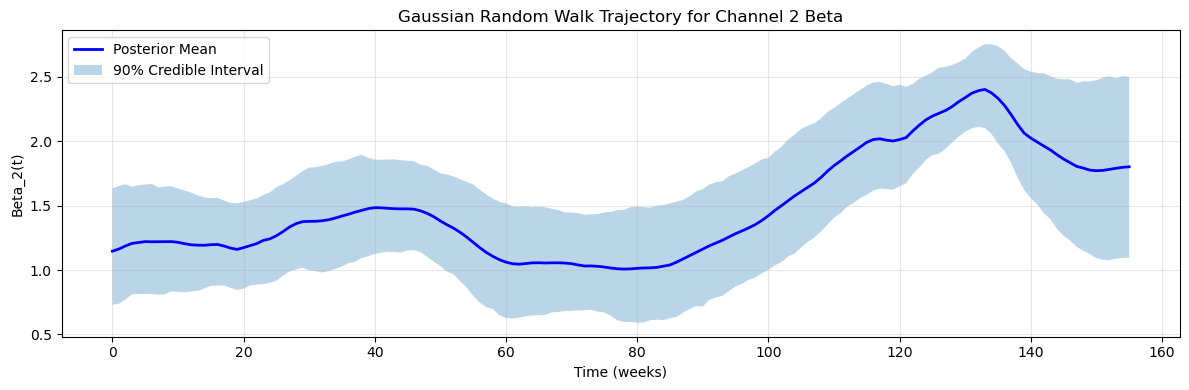


Validating Out-of-Sample Performance of the Dynamic Model
Time-Series Cross-Validation: Dynamic vs Static Models

Split 1/3:
  Training Set: Weeks 0–129 (n=130)
  Test Set: Weeks 130–155 (n=26)
Configuration: 2 chains, 800 draws, 1000 tune


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_lam, sigma_lam, mu_beta, sigma_beta, alpha, lam, beta, intercept, gamma_seasonal, sigma]
Sampling 2 chains for 1_000 tune and 800 draw iterations (2_000 + 1_600 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Building dynamic model: dynamic channels = ['channel_2']
  Channel 1: Static parameter
  Channel 2: Gaussian Random Walk β_t = β_(t-1) + ε_t
  Channel 3: Static parameter

Fitting Dynamic Hierarchical Bayesian MMM...
Configuration: 2 chains, 1000 draws, 1000 tuning steps


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_lam, sigma_lam, mu_beta, sigma_beta, alpha, lam, beta_0_static, sigma_walk_1, beta_1_init, beta_1_inno, beta_2_static, intercept, gamma_seasonal, sigma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 446 seconds.
/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_38631/1320465664.py:173: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain in range(posterior.dims['chain']):
/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_38631/1320465664.py:174: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.di

  Results:
    Static:  MAPE=117.52%, RMSE=3441.9
    Dynamic: MAPE=18.45%, RMSE=574.9
    Improvement: MAPE ↓99.07pp, RMSE ↓2866.9

Split 2/3:
  Training Set: Weeks 0–103 (n=104)
  Test Set: Weeks 104–129 (n=26)
Configuration: 2 chains, 800 draws, 1000 tune


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_lam, sigma_lam, mu_beta, sigma_beta, alpha, lam, beta, intercept, gamma_seasonal, sigma]
Sampling 2 chains for 1_000 tune and 800 draw iterations (2_000 + 1_600 draws total) took 9 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Building dynamic model: dynamic channels = ['channel_2']
  Channel 1: Static parameter
  Channel 2: Gaussian Random Walk β_t = β_(t-1) + ε_t
  Channel 3: Static parameter

Fitting Dynamic Hierarchical Bayesian MMM...
Configuration: 2 chains, 1000 draws, 1000 tuning steps


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_lam, sigma_lam, mu_beta, sigma_beta, alpha, lam, beta_0_static, sigma_walk_1, beta_1_init, beta_1_inno, beta_2_static, intercept, gamma_seasonal, sigma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 204 seconds.
/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_38631/1320465664.py:173: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain in range(posterior.dims['chain']):
/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_38631/1320465664.py:174: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.di

  Results:
    Static:  MAPE=46.19%, RMSE=1647.4
    Dynamic: MAPE=22.03%, RMSE=854.7
    Improvement: MAPE ↓24.16pp, RMSE ↓792.7

Split 3/3:
  Training Set: Weeks 0–77 (n=78)
  Test Set: Weeks 78–103 (n=26)
Configuration: 2 chains, 800 draws, 1000 tune


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_lam, sigma_lam, mu_beta, sigma_beta, alpha, lam, beta, intercept, gamma_seasonal, sigma]
Sampling 2 chains for 1_000 tune and 800 draw iterations (2_000 + 1_600 draws total) took 10 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Building dynamic model: dynamic channels = ['channel_2']
  Channel 1: Static parameter
  Channel 2: Gaussian Random Walk β_t = β_(t-1) + ε_t
  Channel 3: Static parameter

Fitting Dynamic Hierarchical Bayesian MMM...
Configuration: 2 chains, 1000 draws, 1000 tuning steps


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_lam, sigma_lam, mu_beta, sigma_beta, alpha, lam, beta_0_static, sigma_walk_1, beta_1_init, beta_1_inno, beta_2_static, intercept, gamma_seasonal, sigma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 142 seconds.


  Results:
    Static:  MAPE=131.41%, RMSE=3025.8
    Dynamic: MAPE=21.58%, RMSE=514.9
    Improvement: MAPE ↓109.83pp, RMSE ↓2510.9
Cross Validation Summary
Static Model:
  MAPE: 98.37% (±37.33%)
  RMSE: 2705.0 (±766.9)
Dynamic Model:
  MAPE: 20.69% (±1.59%)
  RMSE: 648.2 (±148.1)
Improvement:
  MAPE Reduction: 77.69pp (79.0%)
  RMSE Reduction: 2056.8 (76.0%)

Dynamic model shows significant improvement in out-of-sample prediction.


/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_38631/1320465664.py:173: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain in range(posterior.dims['chain']):
/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_38631/1320465664.py:174: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for draw in range(min(posterior.dims['draw'], 100)):


In [24]:
def run_weeks_5_6():
    print("Dynamic Parameter Module")
    # Generate simulated dataset (156 weeks, 3 channels)
    generator = Data_Generate(n_weeks=156, n_channels=3)
    df, true_params = generator.ds_generate()
    print("\nBuilding Dynamic Parameter Module (Gaussian Random Walk)")
    dynamic_model = dynamic_b()
    # Channel 2 is modeled as dynamic
    dynamic_model.fit(df, dynamic_channels=[1])
    dynamic_model.diagnose()
    dynamic_model.dynamic_para()
    print("\nValidating Out-of-Sample Performance of the Dynamic Model")
    validator = dynamic_valid()
    cv_results = validator.cross_valid(df, true_params)
    return dynamic_model, validator, df, true_params
dynamic_model, validator, df, true_params = run_weeks_5_6()


In [25]:
def run_weeks_7_8(df, true_params):
    print("Systematic Comparison")
    framework = compareall()
    comparison_results = framework.overall_compare(df, true_params)
    return framework, comparison_results
framework, comparison_results = run_weeks_7_8(df, true_params)

Systematic Comparison
Systematic Model Comparison Experiment
Four models: Static, Static+Causal, Dynamic, Dynamic+Causal

Causal Analysis and Prior Preparation
Causal Impact Analysis: channel_1
Treatment Period: Weeks 80-87
Using Control Variables: ['channel_2', 'channel_3', 'channel_1_blackout', 'channel_2_boost', 'time_trend', 'sin_seasonal', 'cos_seasonal', 'external_shock']
Causal Effect: -433.2 (-15.7%)
95% CI: [-503.8, -362.7]
p-value: 0.0000
Counterfactual Model R²: 0.831
Causal Impact Analysis: channel_2
Treatment Period: Weeks 120-131
Using Control Variables: ['channel_1', 'channel_3', 'channel_1_blackout', 'channel_2_boost', 'time_trend', 'sin_seasonal', 'cos_seasonal', 'external_shock']
Causal Effect: 517.1 (14.6%)
95% CI: [362.6, 671.5]
p-value: 0.0001
Counterfactual Model R²: 0.743

Creating Informative Priors...
------------------------------
channel_1: beta prior N(0.767, 0.077)
Based on Causal Effect: -433.2 (p=0.0000)
channel_2: beta prior N(2.182, 0.218)
Based on Caus

Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_lam, sigma_lam, mu_beta, sigma_beta, alpha, lam, beta, intercept, gamma_seasonal, sigma]
Sampling 2 chains for 1_000 tune and 800 draw iterations (2_000 + 1_600 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Number of Divergences: 0
Max R-hat: 1.0000
Min ESS: 557

Model 2: Static + Causal Calibration
Causal calibration information applied to beta[0]
Causal calibration information applied to beta[1]
Configuration: 2 chains, 800 draws, 1000 tune


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_lam, sigma_lam, mu_beta, sigma_beta, alpha, lam, beta, intercept, gamma_seasonal, sigma]
Sampling 2 chains for 1_000 tune and 800 draw iterations (2_000 + 1_600 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Number of Divergences: 0
Max R-hat: 1.0000
Min ESS: 1063

Model 3: Dynamic
Building dynamic model: dynamic channels = ['channel_2']
  Channel 1: Static parameter
  Channel 2: Gaussian Random Walk β_t = β_(t-1) + ε_t
  Channel 3: Static parameter

Fitting Dynamic Hierarchical Bayesian MMM...
Configuration: 2 chains, 1000 draws, 1000 tuning steps


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_lam, sigma_lam, mu_beta, sigma_beta, alpha, lam, beta_0_static, sigma_walk_1, beta_1_init, beta_1_inno, beta_2_static, intercept, gamma_seasonal, sigma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 671 seconds.



Dynamic Hierarchical Bayesian MMM Diagnostics
Divergences: 27
Max R-hat: 1.0000
Min ESS: 794
Channel 2 random walk σ: 0.0814

Model 4: Dynamic + Causal Calibration
Building dynamic model: dynamic channels = ['channel_2']
  Channel 1: Static parameter
  Channel 2: Gaussian Random Walk β_t = β_(t-1) + ε_t
    Using causal calibration prior: N(2.182, 0.218)
  Channel 3: Static parameter

Fitting Dynamic + Causal Calibration Hierarchical Bayesian MMM...
Configuration: 2 chains, 1000 draws, 1000 tuning steps


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_lam, sigma_lam, mu_beta, sigma_beta, alpha, lam, beta_0_static, sigma_walk_1, beta_1_init, beta_1_inno, beta_2_static, intercept, gamma_seasonal, sigma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 511 seconds.
/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_38631/1320465664.py:173: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain in range(posterior.dims['chain']):
/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_38631/1320465664.py:174: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.di


Dynamic Hierarchical Bayesian MMM Diagnostics
Divergences: 19
Max R-hat: 1.0100
Min ESS: 634
Channel 2 random walk σ: 0.0781

Evaluating Predictive Accuracy

Evaluating Predictive Accuracy (MAPE / RMSE / R² / MAE)
static             | MAPE= 79.99% | RMSE= 2637.02 | R²=-17.698 | MAE= 2631.41
static_causal      | MAPE= 79.61% | RMSE= 2618.69 | R²=-17.439 | MAE= 2614.84
dynamic            | MAPE=  8.17% | RMSE=  363.79 | R²= 0.644 | MAE=  298.37


/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_38631/1320465664.py:173: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain in range(posterior.dims['chain']):
/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_38631/1320465664.py:174: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for draw in range(min(posterior.dims['draw'], 100)):


dynamic_causal     | MAPE=  6.22% | RMSE=  267.43 | R²= 0.808 | MAE=  222.18

Summary Table:
         Model MAPE (%)    RMSE      R²     MAE
dynamic_causal     6.22  267.43   0.808  222.18
       dynamic     8.17  363.79   0.644  298.37
 static_causal    79.61 2618.69 -17.439 2614.84
        static    79.99 2637.02 -17.698 2631.41

Evaluating Parameter Recovery Performance
  static: Mean Parameter Error = 34.6%
  static_causal: Mean Parameter Error = 30.6%
  dynamic: Mean Parameter Error = 23.3%
  dynamic_causal: Mean Parameter Error = 27.3%

1. Predictive Accuracy Ranking (by MAPE):
   1. dynamic_causal : 6.22%
   2. dynamic        : 8.17%
   3. static_causal  : 79.61%
   4. static         : 79.99%

2. Parameter Recovery Ranking:
   1. dynamic        : 23.3% error
   2. dynamic_causal : 27.3% error
   3. static_causal  : 30.6% error
   4. static         : 34.6% error

Overall Summary:
  Best Predictive Model: dynamic_causal
  Best Parameter Recovery: dynamic
  → Dynamic parameters sig

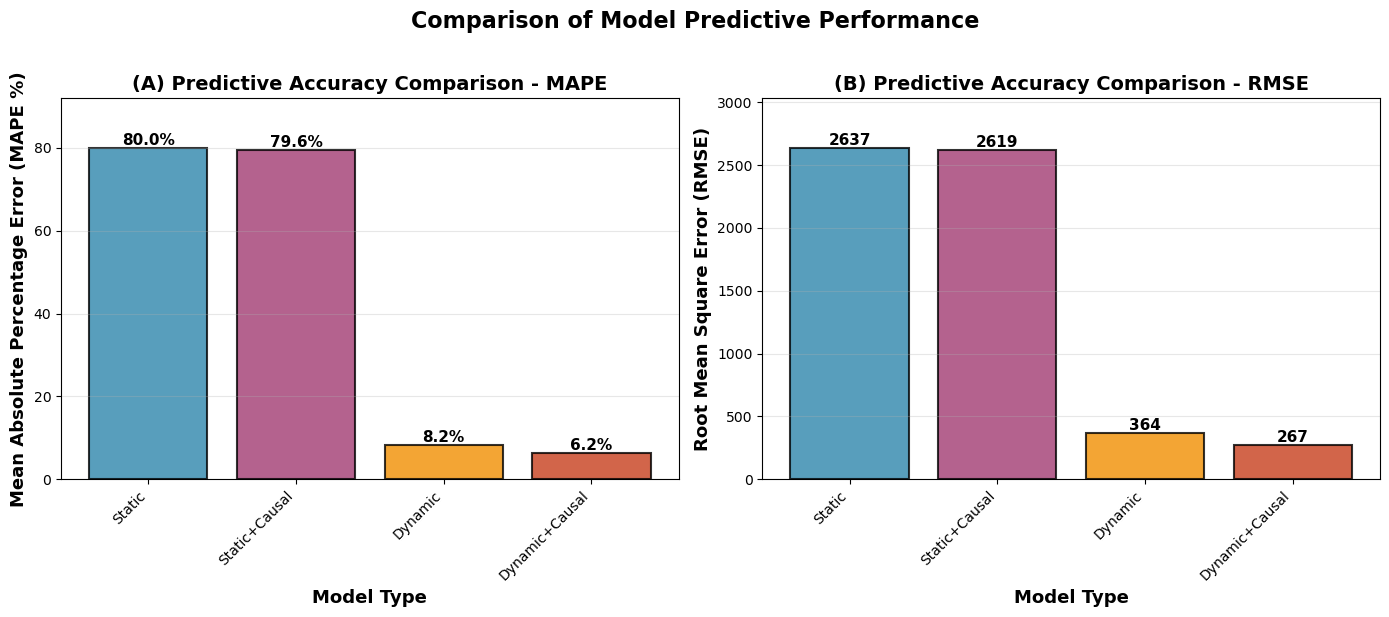

In [39]:
# Visualization Function Collection

m_color = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
m_type = ['Static', 'Static+Causal', 'Dynamic', 'Dynamic+Causal']

def plot_prediction_performance(framework):
    """Compare predictive performance across models."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Retrieve DataFrame and align by model order
    pred_df = framework.pred_results_df
    model_order = ['static', 'static_causal', 'dynamic', 'dynamic_causal']
    mapes = [pred_df.loc[pred_df['Model'] == m, 'MAPE (%)'].values[0] for m in model_order]
    rmses = [pred_df.loc[pred_df['Model'] == m, 'RMSE'].values[0] for m in model_order]

    # Subplot 1: MAPE comparison
    x = np.arange(len(m_type))
    bars1 = ax1.bar(x, mapes, color=m_color, alpha=0.8, edgecolor='black', linewidth=1.5)

    # Add value labels
    for bar, val in zip(bars1, mapes):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax1.set_xlabel('Model Type', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Mean Absolute Percentage Error (MAPE %)', fontsize=13, fontweight='bold')
    ax1.set_title('(A) Predictive Accuracy Comparison - MAPE', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(m_type, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim([0, max(mapes) * 1.15])

    # Subplot 2: RMSE comparison
    bars2 = ax2.bar(x, rmses, color=m_color, alpha=0.8, edgecolor='black', linewidth=1.5)

    for bar, val in zip(bars2, rmses):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{val:.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax2.set_xlabel('Model Type', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Root Mean Square Error (RMSE)', fontsize=13, fontweight='bold')
    ax2.set_title('(B) Predictive Accuracy Comparison - RMSE', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(m_type, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim([0, max(rmses) * 1.15])
    plt.suptitle('Comparison of Model Predictive Performance',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

fig1 = plot_prediction_performance(framework)
plt.show()


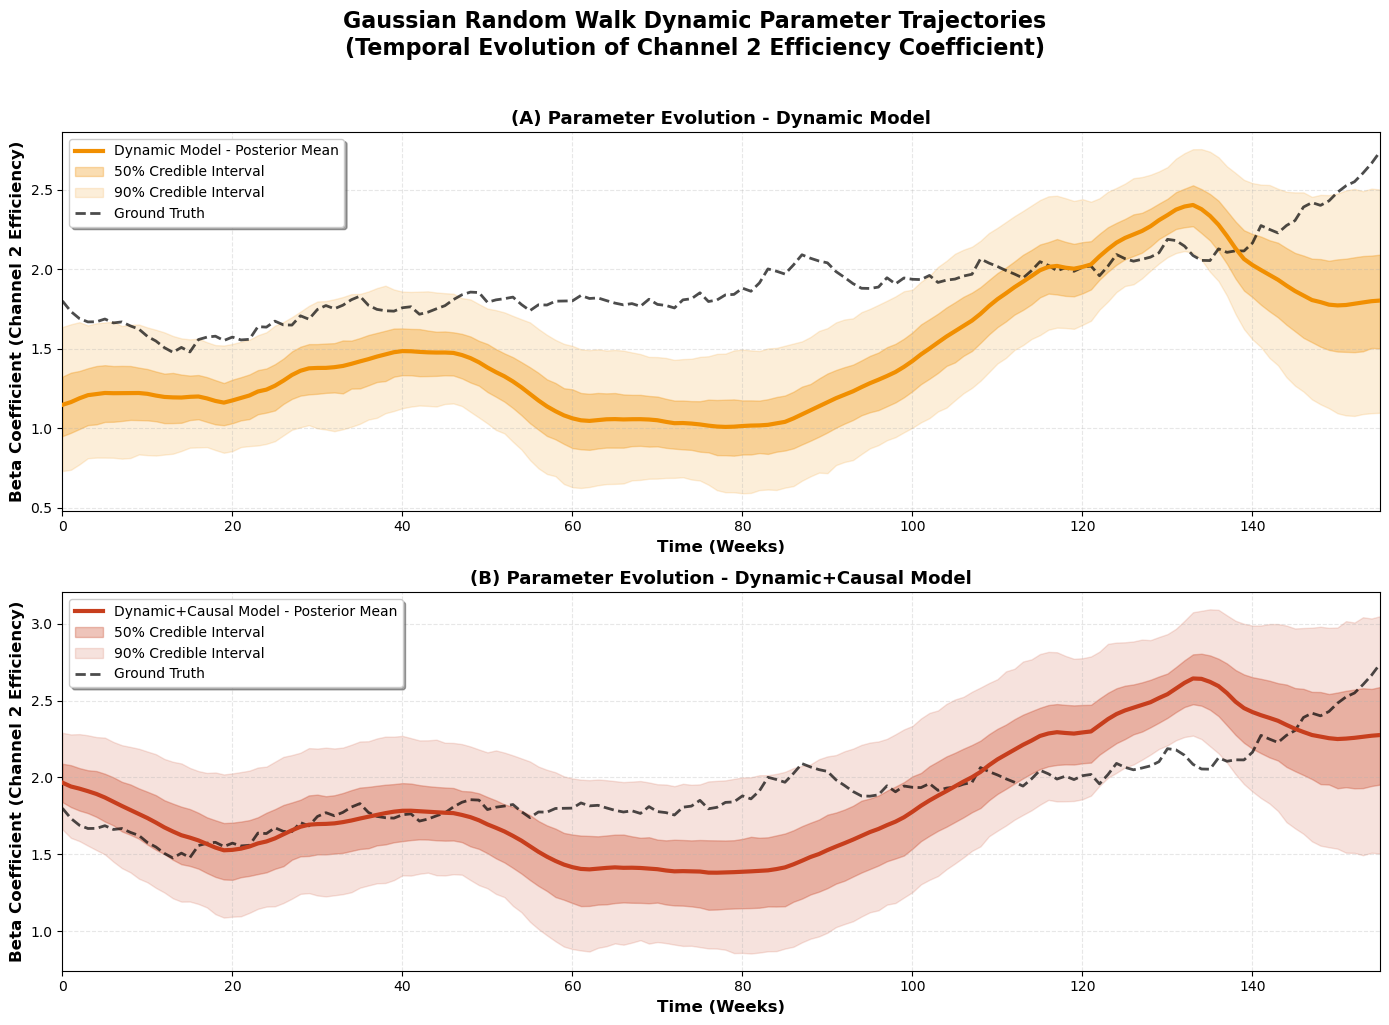

In [40]:
def dynamicparam_evo(framework, true_params):
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    # Get dynamic models
    dynamic_model = framework.models['dynamic']
    dynamic_causal_model = framework.models['dynamic_causal']
    models_to_plot = [
        (dynamic_model, 'Dynamic Model', color[2]),
        (dynamic_causal_model, 'Dynamic+Causal Model', color[3])
    ]
    for ax_idx, (model, model_name, model_color) in enumerate(models_to_plot):
        ax = axes[ax_idx]
        posterior = model.idata.posterior
        # Extract dynamic beta trajectory for Channel 2
        i = 1  # Channel 2
        beta_init = posterior[f'beta_{i}_init'].values.flatten()
        inno = posterior[f'beta_{i}_inno'].values
        n_samples = len(beta_init)
        n_time = inno.shape[-1] + 1
        trajs = np.zeros((n_samples, n_time))
        for s in range(n_samples):
            trajs[s, 0] = beta_init[s]
            cumsum = beta_init[s]
            for t in range(n_time - 1):
                cumsum += inno.reshape(n_samples, -1)[s, t]
                trajs[s, t + 1] = cumsum
        # Compute statistics
        mean_traj = trajs.mean(axis=0)
        q05_traj = np.quantile(trajs, 0.05, axis=0)
        q25_traj = np.quantile(trajs, 0.25, axis=0)
        q75_traj = np.quantile(trajs, 0.75, axis=0)
        q95_traj = np.quantile(trajs, 0.95, axis=0)
        time_points = np.arange(n_time)
        ax.plot(time_points, mean_traj, '-', color=model_color, linewidth=3, 
                label=f'{model_name} - Posterior Mean', zorder=3)
        ax.fill_between(time_points, q25_traj, q75_traj, 
                        color=model_color, alpha=0.3, label='50% Credible Interval')
        ax.fill_between(time_points, q05_traj, q95_traj, 
                        color=model_color, alpha=0.15, label='90% Credible Interval')
        # Add true trajectory
        if 'beta' in true_params:
            true_beta = true_params['beta'][:n_time, 1]
            ax.plot(time_points, true_beta, 'k--', linewidth=2, 
                    alpha=0.7, label='Ground Truth')
        ax.set_xlabel('Time (Weeks)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Beta Coefficient (Channel 2 Efficiency)', fontsize=12, fontweight='bold')
        ax.set_title(f'({chr(65 + ax_idx)}) Parameter Evolution - {model_name}', 
                     fontsize=13, fontweight='bold')
        ax.legend(loc='best', fontsize=10, frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xlim([0, n_time - 1])
    plt.suptitle('Gaussian Random Walk Dynamic Parameter Trajectories\n(Temporal Evolution of Channel 2 Efficiency Coefficient)', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig
# Figure 3: Dynamic Parameter Trajectories
fig3 = dynamicparam_evo(framework, true_params)
plt.show()



,split,train_size,test_size,static_mape,dynamic_mape,improvement
0,1,130,26,117.517470,18.451263,99.066207
1,2,104,26,46.194742,22.034386,24.160356
2,3,78,26,131.409626,21.580132,109.829494


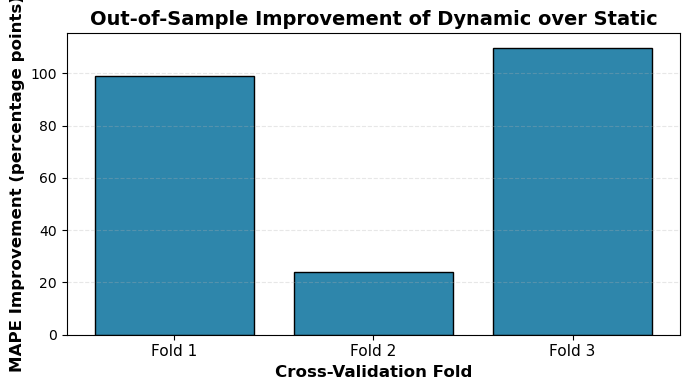

,Model,MAPE (%),RMSE,R²,MAE
3,dynamic_causal,6.224719,267.432309,0.807691,222.176494
2,dynamic,8.171117,363.789224,0.644146,298.367376
1,static_causal,79.612487,2618.693308,-17.439153,2614.840930
0,static,79.993149,2637.021303,-17.698164,2631.405302


,Model,Mean Error (%),Num Params
2,dynamic,23.251869,9
3,dynamic_causal,27.265590,9
1,static_causal,30.646000,9
0,static,34.647426,9


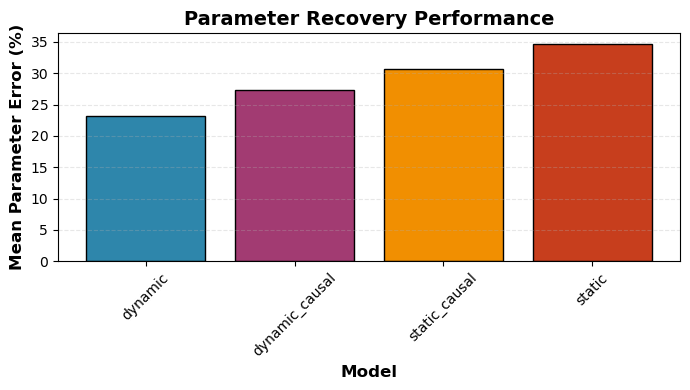

,Metric,Best Model,Best Score
0,Predictive Accuracy (MAPE),dynamic_causal,6.22%
1,Parameter Recovery,dynamic,23.3%


In [42]:
cv_df = pd.DataFrame(validator.cv_details)
display(cv_df.style.set_caption("Cross-Validation Results: Dynamic vs Static Models"))

plt.figure(figsize=(7,4))
plt.bar(cv_df['split'], cv_df['improvement'], 
        color='#2E86AB', edgecolor='black')
plt.xticks(cv_df['split'], [f"Fold {i}" for i in cv_df['split']], fontsize=11)
plt.xlabel('Cross-Validation Fold', fontsize=12, fontweight='bold')
plt.ylabel('MAPE Improvement (percentage points)', fontsize=12, fontweight='bold')
plt.title('Out-of-Sample Improvement of Dynamic over Static', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, linestyle='--', axis='y')
plt.tight_layout()
plt.show()

pred_df = framework.pred_results_df.copy()
display(pred_df.style.set_caption("Predictive Performance across Four Models"))

recovery_dict = framework.results['recovery']
recovery_df = pd.DataFrame([
    {'Model': m, 'Mean Error (%)': v['mean_error'], 'Num Params': v['n_params']}
    for m, v in recovery_dict.items()
]).sort_values(by='Mean Error (%)')

display(recovery_df.style.set_caption("Parameter Recovery Accuracy"))

plt.figure(figsize=(7,4))
plt.bar(recovery_df['Model'], recovery_df['Mean Error (%)'],
        color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'], edgecolor='black')
plt.ylabel('Mean Parameter Error (%)', fontsize=12, fontweight='bold')
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.title('Parameter Recovery Performance', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(alpha=0.3, linestyle='--', axis='y')
plt.tight_layout()
plt.show()

best_pred_model = pred_df.iloc[0]['Model']
best_recovery_model = recovery_df.iloc[0]['Model']
summary_table = pd.DataFrame([
    ['Predictive Accuracy (MAPE)', best_pred_model, f"{pred_df['MAPE (%)'].min():.2f}%"],
    ['Parameter Recovery', best_recovery_model, f"{recovery_df['Mean Error (%)'].min():.1f}%"]
], columns=['Metric', 'Best Model', 'Best Score'])

display(summary_table.style.set_caption("Overall Best Models Summary"))
